In [1]:
import pickle
import numpy as np 
import pandas as pd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os 
import glob
import root_pandas

mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams["image.origin"] = 'lower'

Welcome to JupyROOT 6.20/02


In [2]:
output_dir = "/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/validation_plots/deepSC_v6_newmodel_wps/"
input_version = "9"
inputdir = "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/"

In [3]:
from tensorflow import keras
model_EB = keras.models.load_model("../models/v6_detseparated/model_v2_EB.hd5")
scaler_EB = pickle.load(open("../models/v6_detseparated/scaler_model_v2_EB.pkl", "rb"))
model_EE = keras.models.load_model("../models/v6_detseparated/model_v1_EE.hd5")
scaler_EE = pickle.load(open("../models/v6_detseparated/scaler_model_v1_EE.pkl", "rb"))

W0505 15:14:54.552293 139638596241216 deprecation.py:323] From /cvmfs/sft.cern.ch/lcg/views/LCG_97python3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0505 15:14:54.875784 139638596241216 deprecation.py:506] From /cvmfs/sft.cern.ch/lcg/views/LCG_97python3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/adagrad.py:105: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
2020-05-05 15:14:54.410410: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that th

## Load data
Seed is included

In [4]:
i = 0
nfiles = 5

datas_ele= []
for f in glob.glob(inputdir+ "electrons/numpy_v{}/testing/clusters_data_*.pkl".format(input_version)):
    i+=1
    if i >nfiles: break
    d = pickle.load(open(f, "rb"))
    datas_ele.append( d[(d.is_calo_matched == True)] )

data_ele = pd.concat(datas_ele, ignore_index=True)
data_ele["particle"] = "electron"
print("N events ele: ",len(data_ele))

i = 0
datas_gamma = []
for f in glob.glob(inputdir+ "gammas/numpy_v{}/testing/clusters_data_*.pkl".format(input_version)):
    i+=1
    if i >nfiles: break
    d = pickle.load(open(f, "rb"))
    datas_gamma.append(d[ (d.is_calo_matched == True)])
    
data_gamma = pd.concat(datas_gamma, ignore_index=True)
data_gamma["particle"] = "gamma"
print("N events gamma: ",len(data_gamma))

if data_ele.shape[0]> data_gamma.shape[0]:
    data_val = pd.concat([data_gamma, data_ele.iloc[0:len(data_gamma)]], ignore_index=True)
else:
    data_val = pd.concat([data_gamma.iloc[0:len(data_ele)], data_ele], ignore_index=True)

print(f"N samples ele {data_ele.shape}")
print(f"N samples gamma {data_gamma.shape}")


data_val = pd.concat([data_ele, data_gamma])

N events ele:  2325209
N events gamma:  2251286
N samples ele (2325209, 32)
N samples gamma (2251286, 32)


In [5]:
print(f"N samples ele {data_ele.shape}")
print(f"N samples gamma {data_gamma.shape}")

N samples ele (2325209, 32)
N samples gamma (2251286, 32)


# Evaluation

In [6]:
cols = ["seed_eta", "seed_phi", "seed_iz","en_seed","et_seed",
        "cluster_deta", "cluster_dphi", "en_cluster", "et_cluster",
       "seed_f5_r9", "seed_f5_sigmaIetaIeta","seed_f5_sigmaIetaIphi","seed_f5_sigmaIphiIphi","seed_swissCross","seed_nxtals",
        "cl_f5_r9", "cl_f5_sigmaIetaIeta","cl_f5_sigmaIetaIphi","cl_f5_sigmaIphiIphi","cl_swissCross", "cl_nxtals"]

In [7]:
data_EB = data_val[abs(data_val.seed_eta)<1.479]
data_EE = data_val[abs(data_val.seed_eta)>=1.479]

data_EB["y"] = model_EB.predict(scaler_EB.transform(data_EB[cols].values), batch_size=2048)
data_EE["y"] = model_EE.predict(scaler_EE.transform(data_EE[cols].values), batch_size=2048)

data_val = pd.concat([data_EB, data_EE])

/usr/local/bin/start_ipykernel.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/usr/local/bin/start_ipykernel.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [19]:
data_out = data_val[data_val.in_scluster== False]
data_in = data_val[data_val.in_scluster == True]

### Mustache efficiency

In [18]:
TP_must = data_val[(data_val.in_scluster==True) & ( data_val.in_mustache==True) ]
TN_must = data_val[(data_val.in_scluster==False) & ( data_val.in_mustache==False) ]
FP_must = data_val[(data_val.in_scluster==False) & ( data_val.in_mustache==True) ]
FN_must = data_val[(data_val.in_scluster==True) & ( data_val.in_mustache==False) ]
T_must = data_val[data_val.in_scluster==True]
F_must = data_val[data_val.in_scluster==False]

In [12]:
print(f"Background contamination {len(FP_must)/len(F_must)}")
print(f"Signal efficiency {len(TP_must)/len(T_must)}")

Background contamination 0.07690516775454205
Signal efficiency 0.8326263144225198


## ROCs by energy

In [15]:
data_val.columns

Index(['cluster_deta', 'cluster_dphi', 'cluster_iz', 'en_cluster', 'en_seed',
       'en_true', 'f5_r9', 'f5_sigmaIetaIeta', 'f5_sigmaIetaIphi',
       'f5_sigmaIphiIphi', 'in_mustache', 'in_scluster', 'index', 'is_calo',
       'is_seed', 'max_dr_cluster', 'max_en_cluster', 'nclusters', 'nxtals',
       'seed_eta', 'seed_iz', 'seed_phi', 'swissCross', 'window_index',
       'particle', 'y_baseline', 'y_shower'],
      dtype='object')

## Barrell

In [20]:
data_val.head()

,cl_f5_r9,cl_f5_sigmaIetaIeta,cl_f5_sigmaIetaIphi,cl_f5_sigmaIphiIphi,cl_nxtals,cl_swissCross,cluster_deta,cluster_dphi,cluster_iz,en_cluster,...,seed_f5_sigmaIetaIeta,seed_f5_sigmaIetaIphi,seed_f5_sigmaIphiIphi,seed_iz,seed_nxtals,seed_phi,seed_swissCross,window_index,particle,y
1,0.969308,0.008023,0.000008,0.012355,17,0.514219,0.000000,0.000000,0,152.729462,...,0.008023,0.000008,0.012355,0,17,-1.789789,0.514219,vdtlyqgs,electron,0.999660
4,0.948297,0.010394,0.000035,0.017169,5,0.242622,0.000000,0.000000,0,4.195239,...,0.010394,0.000035,0.017169,0,5,-1.745137,0.242622,xrsmbzor,electron,0.998746
7,1.000000,0.000000,0.000000,0.009351,2,0.775096,0.125969,0.259000,0,3.724196,...,0.010394,0.000035,0.017169,0,5,-1.745137,0.242622,xrsmbzor,electron,0.007132
8,1.000000,0.019569,0.000195,0.012858,3,0.293452,0.164622,0.327646,0,3.505830,...,0.010394,0.000035,0.017169,0,5,-1.745137,0.242622,xrsmbzor,electron,0.009165
10,0.827588,0.014224,0.000000,0.000000,3,0.073108,0.125936,-0.026865,0,2.743200,...,0.010394,0.000035,0.017169,0,5,-1.745137,0.242622,xrsmbzor,electron,0.008304


In [8]:
thresholds = [0.4,0.7,0.8,0.85, 0.873,0.9,0.95,0.99]

results = {}

for t in thresholds:

    g = data_val[(data_val.y >  t) | (data_val.is_seed==True)].groupby("window_index", sort=False).agg(
                        { "en_cluster": 'sum', 
                          "en_true": "first", 
                          "en_seed": "first",
                          "seed_eta": "first",
                          "seed_phi": "first"})
    g["ratio"] = g["en_cluster"] / g["en_true"]
    
    results[t] = g

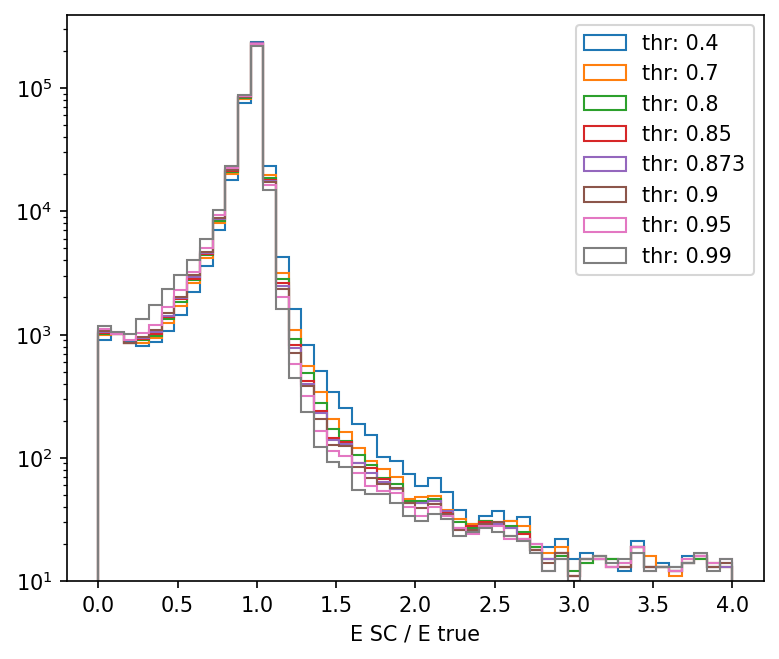

In [9]:
fig, _ = plt.subplots(figsize=(6,5), dpi=150)
for t , g in results.items():
    plt.hist(g.ratio, range=(0,4), bins=50,  histtype="step", label=f"thr: {t}", log=True, bottom=10)
plt.xlabel("E SC / E true")
plt.legend()

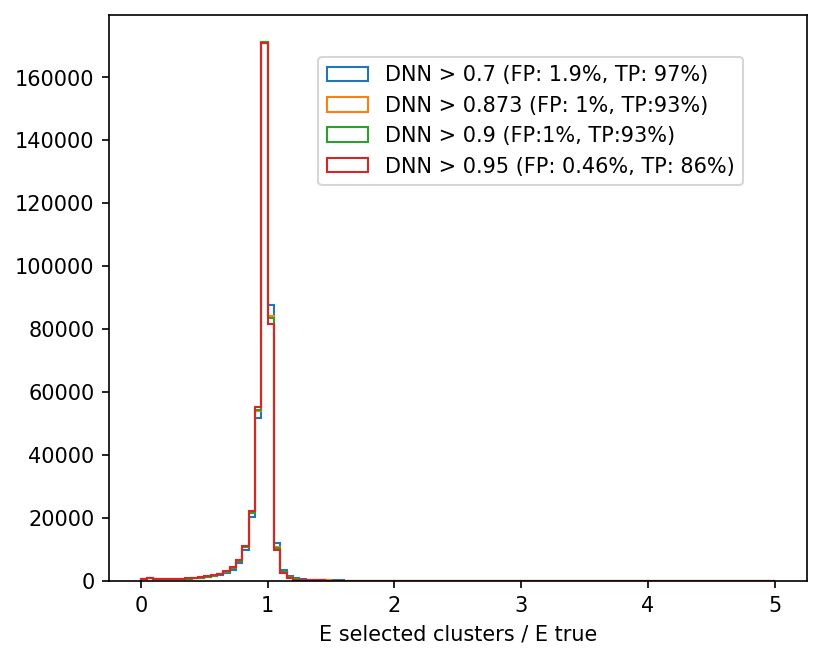

In [10]:
fig, ax = plt.subplots(figsize=(6,5), dpi=150)

info =    {
           0.7: "FP: 1.9%, TP: 97%", 
           0.873: "FP: 1%, TP:93%",
           0.9: "FP:1%, TP:93%",
           0.95: "FP: 0.46%, TP: 86%"}

for t , g in results.items():
    if t  not in [0.7, 0.873, 0.9, 0.95]: continue
    ax.hist(g.ratio, range=(0,5), bins=100,  histtype="step", label=f"DNN > {t} ({info[t]})",  bottom=1e2)
ax.set_xlabel("E selected clusters / E true")
ax.legend(loc=(0.3, 0.7))

# Export tree

In [29]:
ens = [ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
dnn_thres =  np.linspace(0.5 ,1, 30)[:-1]
print(dnn_thres)
eta_range = [0,1.479]
results = []
for thr in dnn_thres:
    #print("DNN threshold: ", thr)
    g = data_val[(abs(data_val.seed_eta)>=eta_range[0]) & (abs(data_val.seed_eta)< eta_range[1]) &
                 ( (data_val.y >  thr) | (data_val.is_seed==True) ) ].groupby("window_index", sort=False).agg(
                            { "en_cluster": 'sum' ,
                              "en_true": "min", 
                              "et_seed": "first",
                              "et_true": "first",
                              "seed_eta": "first",
                              })
    #print(g)
    g["EoEtrue"] = g["en_cluster"] / g["en_true"]
    g["en_bin"] = pd.cut(g["et_seed"], ens, labels=list(range(len(ens)-1)))
    g["dnn_thre"] = thr
    results.append(g)

result = pd.concat(results)

root_pandas.to_root(result[["en_cluster", "en_true", "et_seed", "seed_eta","et_true", "EoEtrue", "dnn_thre"]], 
                        "../models/v5_dynamicwindow/result_scan_model_v5_EB.root", key="resolution_scan")

[0.5        0.51724138 0.53448276 0.55172414 0.56896552 0.5862069
 0.60344828 0.62068966 0.63793103 0.65517241 0.67241379 0.68965517
 0.70689655 0.72413793 0.74137931 0.75862069 0.77586207 0.79310345
 0.81034483 0.82758621 0.84482759 0.86206897 0.87931034 0.89655172
 0.9137931  0.93103448 0.94827586 0.96551724 0.98275862]


In [30]:
ens = [ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
dnn_thres =  np.linspace(0.5 ,1, 30)[:-1]
print(dnn_thres)
eta_range = [1.479,3]
results = []
for thr in dnn_thres:
    #print("DNN threshold: ", thr)
    g = data_val[(abs(data_val.seed_eta)>=eta_range[0]) & (abs(data_val.seed_eta)< eta_range[1]) &
                 ( (data_val.y >  thr) | (data_val.is_seed==True) ) ].groupby("window_index", sort=False).agg(
                            { "en_cluster": 'sum' ,
                              "en_true": "min", 
                              "et_seed": "first",
                              "et_true": "first",
                              "seed_eta": "first",
                              })
    #print(g)
    g["EoEtrue"] = g["en_cluster"] / g["en_true"]
    g["en_bin"] = pd.cut(g["et_seed"], ens, labels=list(range(len(ens)-1)))
    g["dnn_thre"] = thr
    results.append(g)

result = pd.concat(results)

root_pandas.to_root(result[["en_cluster", "en_true", "et_seed","seed_eta", "et_true", "EoEtrue", "dnn_thre"]], 
                        "../models/v5_dynamicwindow/result_scan_model_v5_EE.root", key="resolution_scan")

[0.5        0.51724138 0.53448276 0.55172414 0.56896552 0.5862069
 0.60344828 0.62068966 0.63793103 0.65517241 0.67241379 0.68965517
 0.70689655 0.72413793 0.74137931 0.75862069 0.77586207 0.79310345
 0.81034483 0.82758621 0.84482759 0.86206897 0.87931034 0.89655172
 0.9137931  0.93103448 0.94827586 0.96551724 0.98275862]


In [32]:
ens = [ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
eta_range = [0,1.479]

#print("DNN threshold: ", thr)
g = data_val[(abs(data_val.seed_eta)>=eta_range[0]) & (abs(data_val.seed_eta)< eta_range[1]) &
              (data_val.in_mustache == True) ].groupby("window_index", sort=False).agg(
                        { "en_cluster": 'sum' ,
                          "en_true": "min", 
                          "et_seed": "first",
                          "et_true": "first",
                          "seed_eta": "first",
                          })
#print(g)
g["EoEtrue"] = g["en_cluster"] / g["en_true"]
g["en_bin"] = pd.cut(g["et_seed"], ens, labels=list(range(len(ens)-1)))

root_pandas.to_root(g[["en_cluster", "en_true", "et_seed","seed_eta", "et_true", "EoEtrue"]], 
                        "../models/v5_dynamicwindow/result_scan_mustache_EB.root", key="resolution_scan")

In [33]:
ens = [ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
eta_range = [1.479,3]

#print("DNN threshold: ", thr)
g = data_val[(abs(data_val.seed_eta)>=eta_range[0]) & (abs(data_val.seed_eta)< eta_range[1]) &
              (data_val.in_mustache == True) ].groupby("window_index", sort=False).agg(
                        { "en_cluster": 'sum' ,
                          "en_true": "min", 
                          "et_seed": "first",
                          "et_true": "first",
                          "seed_eta": "first",
                          })
#print(g)
g["EoEtrue"] = g["en_cluster"] / g["en_true"]
g["en_bin"] = pd.cut(g["et_seed"], ens, labels=list(range(len(ens)-1)))

root_pandas.to_root(g[["en_cluster", "en_true", "et_seed","seed_eta", "et_true", "EoEtrue"]], 
                        "../models/v5_dynamicwindow/result_scan_mustache_EE.root", key="resolution_scan")

# Scale and resolution by DNN threshold and ET seed
## Barrel

### By Et seed

In [7]:
eta_range = [0,1.479]
ens = [ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
dnn_thres =  np.linspace(0.1 ,1, 40)[:-1]



results= []

def bin_analysis(group):
    ratio_left = group["EoEtrue"].quantile(0.16)
    ratio_right = group["EoEtrue"].quantile(0.84)
    ratio_mean = group[(group.EoEtrue >= ratio_left) & (group.EoEtrue <= ratio_right) ].EoEtrue.mean()
    return pd.Series(  
        { 
             "EoEtrue_68scale": ratio_mean,
             "EoEtrue_68width": (abs(ratio_right-ratio_mean) + abs(ratio_left-ratio_mean))/2, 
             "EoEtrue_scale":  group.EoEtrue.mean(),
             "EoEtrue_rms":  group.EoEtrue.std()
        })

for thr in dnn_thres:
    #print("DNN threshold: ", thr)
    g = data_val[(abs(data_val.seed_eta)>=eta_range[0]) & (abs(data_val.seed_eta)< eta_range[1]) &
                 ( (data_val.y >  thr) | (data_val.is_seed==True) ) ].groupby("window_index", sort=False).agg(
                            { "en_cluster": 'sum' ,
                              "en_true": "min", 
                              "et_seed": "first",
                              })
    g.columns = ["en_cluster", "en_true", "et_seed"]
    #print(g)
    g["EoEtrue"] = g["en_cluster"] / g["en_true"]
    g["en_bin"] = pd.cut(g["et_seed"], ens, labels=list(range(len(ens)-1)))
    
    scanres = g.groupby("en_bin").apply(bin_analysis)
    scanres["dnn_thre"] = thr
    results.append(scanres)

result_eb = pd.concat(results)
#result.columns = ["_".join(col_name).rstrip('_') for col_name in result.columns.to_flat_index()]

# index by en_bin and DNN threshold
result_eb.reset_index(level=0, inplace=True)

g = data_val[(abs(data_val.seed_eta)>=eta_range[0]) & (abs(data_val.seed_eta)<eta_range[1]) &
             (data_val.in_mustache==True) ].groupby("window_index", sort=False).agg(
                        { "en_cluster": 'sum' ,
                              "en_true": "min", 
                              "et_seed": "first",
                              })
#print(g)
g["EoEtrue"] = g["en_cluster"] / g["en_true"]
g["en_bin"] = pd.cut(g["et_seed"], ens, labels=list(range(len(ens)-1)))

result_eb_must = g.groupby("en_bin").apply(bin_analysis)

result_eb_must.reset_index(level=0, inplace=True)

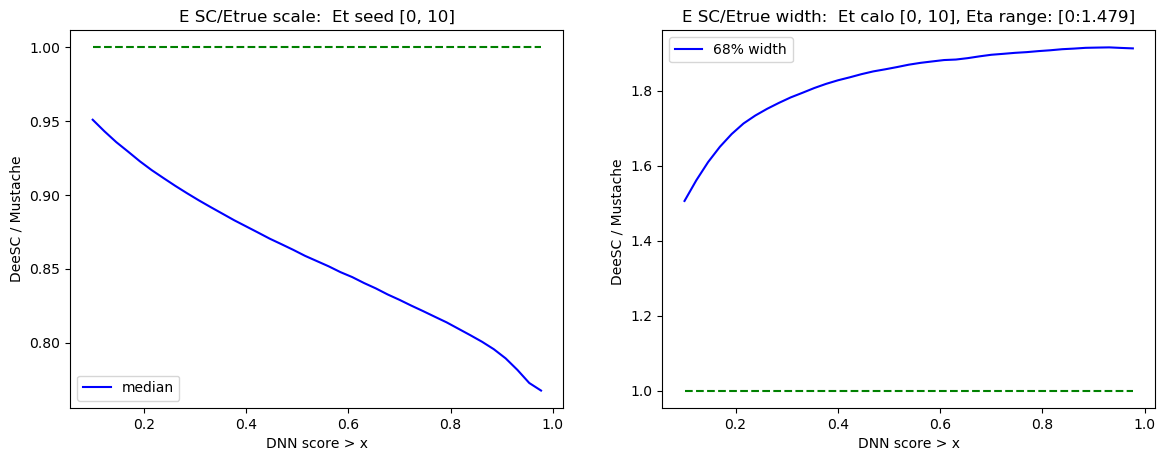

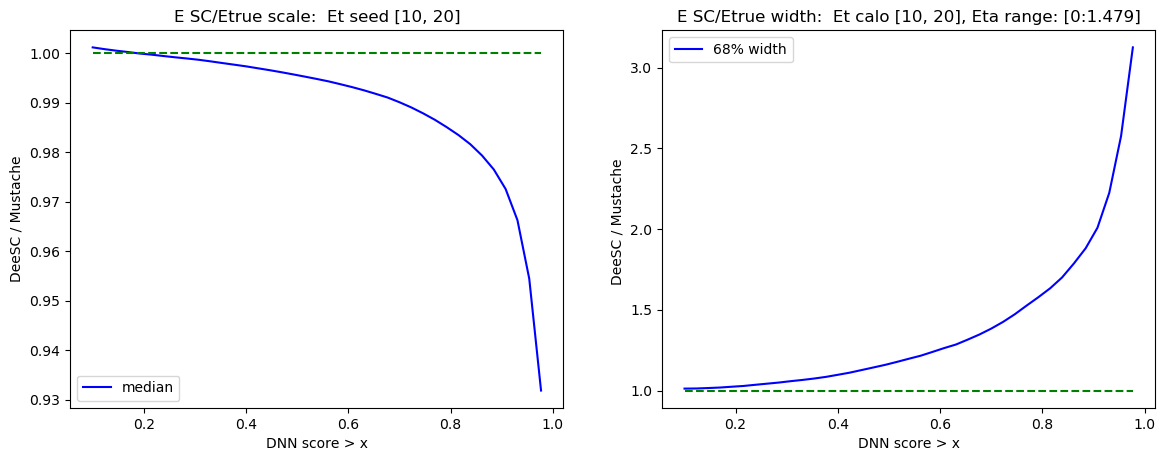

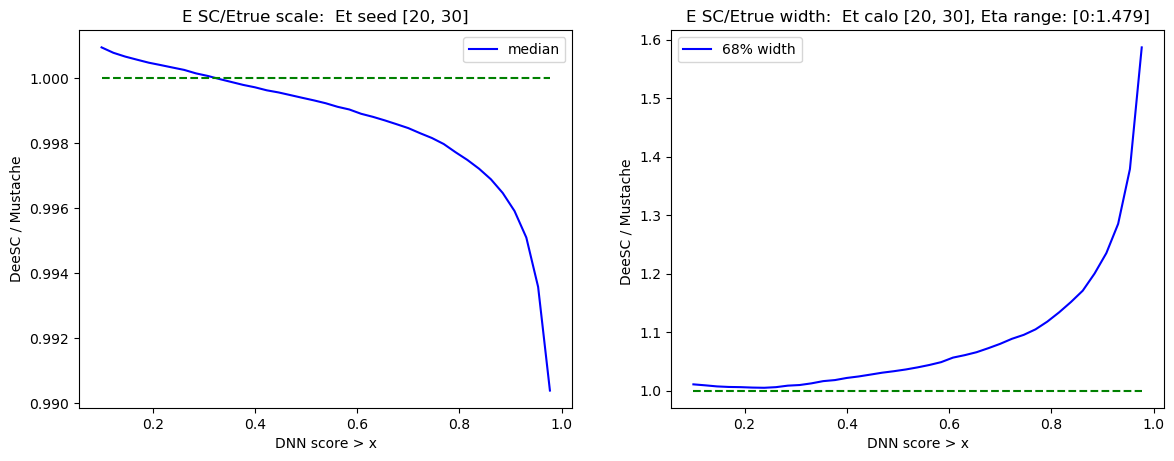

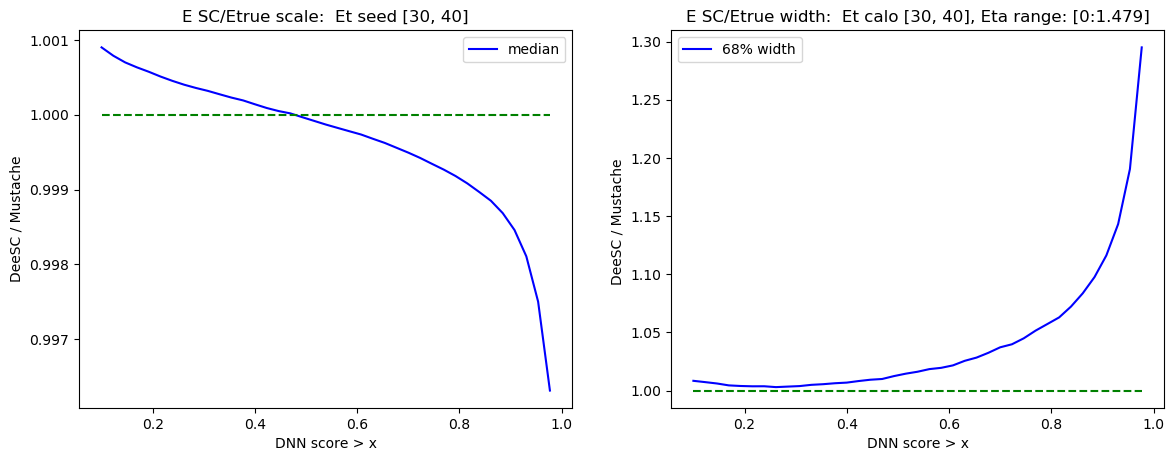

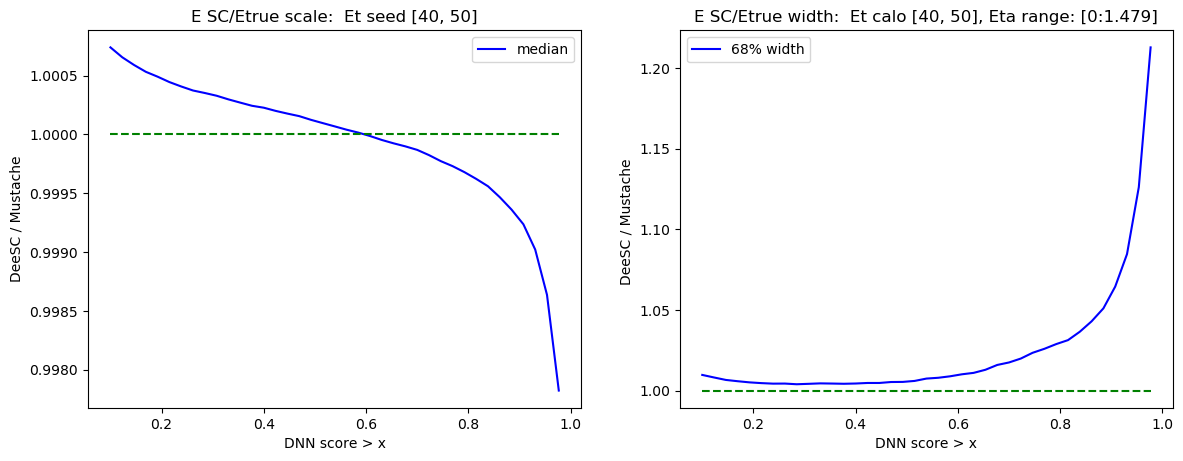

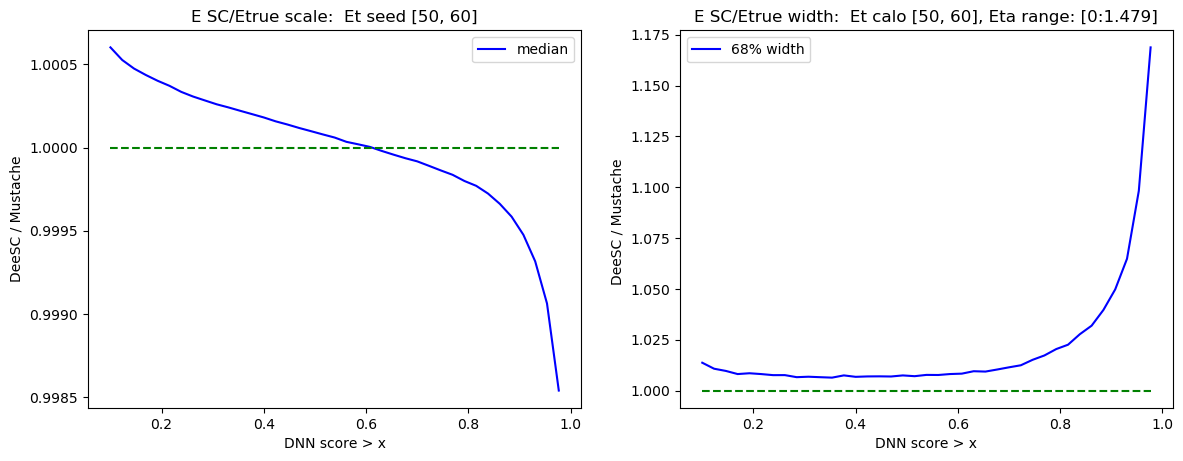

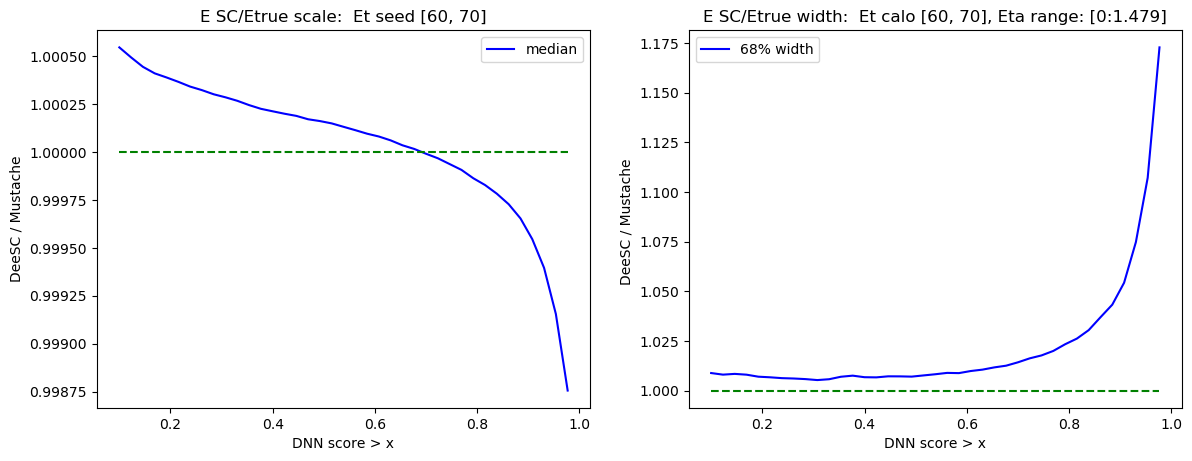

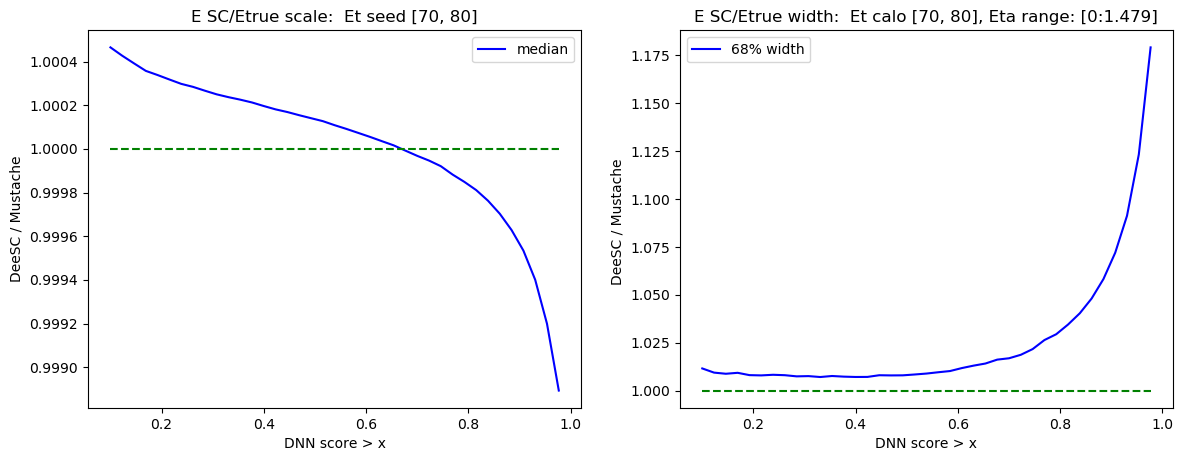

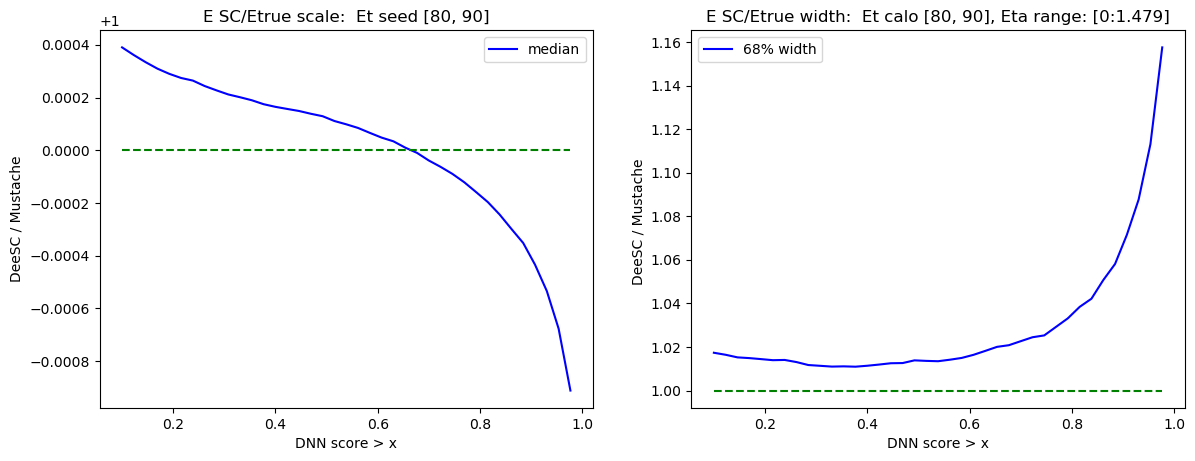

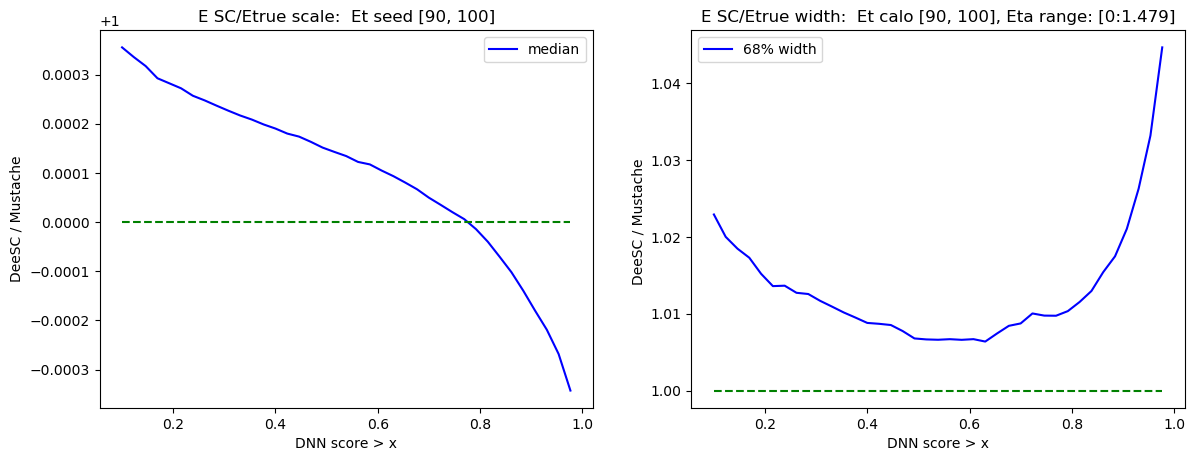

In [8]:
for enbin in range(len(ens)-1):
    
    fig, [ax1,ax2] = plt.subplots(1,2, figsize=(14,5), dpi=100)
    df = result_eb[(result_eb.en_bin==enbin)]
    x = df.dnn_thre.values
    
    # scale
    y = df["EoEtrue_68scale"].values
    y_must = result_eb_must[result_eb_must.en_bin==enbin]["EoEtrue_68scale"].iloc[0]
    ax1.plot(x, y/y_must, "b",label="median")
    ax1.plot(x, [1.]*len(x), "g--")
    #ax1.plot(x, [y_must]*len(x),"r", label= "Mustache 68% scale")
    
    #y = df["EoEtrue_scale"].values
    #y_must = result_eb_must[result_eb_must.en_bin==enbin]["EoEtrue_scale"].iloc[0]
    #ax1.plot(x, y/y_must, "r",label="scale")
    #ax1.plot(x, [y_must]*len(x),"r+", label="Mustache scale")
    
    ax1.legend()
    ax1.set_xlabel("DNN score > x")
    ax1.set_ylabel("DeeSC / Mustache")
    ax1.set_title(f"E SC/Etrue scale:  Et seed [{ens[enbin]}, {ens[enbin+1]}]")
    
    ##### width
    y = df["EoEtrue_68width"].values
    y_must = result_eb_must[result_eb_must.en_bin==enbin]["EoEtrue_68width"].iloc[0]
    
    ax2.plot(x, y/y_must,  "b", label="68% width",)
    ax2.plot(x, [1.]*len(x), "g--")
    #ax2.plot(x, [y_must]*len(x),  "r", label= "Mustache 68% width",)
    
    #y = df["EoEtrue_rms"].values
    #y_must = result_eb_must[result_eb_must.en_bin==enbin]["EoEtrue_rms"].iloc[0]
    #ax2.plot(x, y/y_must,  "r", label="rms width",)
    #ax3.plot(x, [y_must]*len(x), "r+", label="Mustache scale", )
    
    ax2.legend()
    ax2.set_xlabel("DNN score > x")
    ax2.set_ylabel("DeeSC / Mustache ")
    ax2.set_title(f"E SC/Etrue width:  Et calo [{ens[enbin]}, {ens[enbin+1]}], Eta range: [{eta_range[0]}:{eta_range[1]}]")
    
    fig.savefig(output_dir +f"barrel/scale_width_eta_{eta_range[0]}_{eta_range[1]}_et_{ens[enbin]}_{ens[enbin+1]}_seed.png")
    
    

## By ET calo

In [27]:
eta_range = [0, 1.479]
ens = [ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
dnn_thres =  np.linspace(0.1 ,1, 40)[:-1]



results= []

def bin_analysis(group):
    ratio_left = group["EoEtrue"].quantile(0.16)
    ratio_right = group["EoEtrue"].quantile(0.84)
    ratio_mean = group[(group.EoEtrue >= ratio_left) & (group.EoEtrue <= ratio_right) ].EoEtrue.mean()
    return pd.Series(  
        { 
             "EoEtrue_68scale": ratio_mean,
             "EoEtrue_68width": (abs(ratio_right-ratio_mean) + abs(ratio_left-ratio_mean))/2, 
             "EoEtrue_scale":  group.EoEtrue.mean(),
             "EoEtrue_rms":  group.EoEtrue.std()
        })

for thr in dnn_thres:
    #print("DNN threshold: ", thr)
    g = data_val[(abs(data_val.seed_eta)>=eta_range[0]) & (abs(data_val.seed_eta)< eta_range[1]) &
                 ( (data_val.y >  thr) | (data_val.is_seed==True) ) ].groupby("window_index", sort=False).agg(
                            { "en_cluster": 'sum' ,
                              "en_true": "min", 
                              "et_true": "first",
                              })
    #print(g)
    g["EoEtrue"] = g["en_cluster"] / g["en_true"]
    g["en_bin"] = pd.cut(g["et_true"], ens, labels=list(range(len(ens)-1)))
    
    scanres = g.groupby("en_bin").apply(bin_analysis)
    scanres["dnn_thre"] = thr
    results.append(scanres)

result_eb = pd.concat(results)
#result.columns = ["_".join(col_name).rstrip('_') for col_name in result.columns.to_flat_index()]

# index by en_bin and DNN threshold
result_eb.reset_index(level=0, inplace=True)

g = data_val[(abs(data_val.seed_eta)>=eta_range[0]) & (abs(data_val.seed_eta)<eta_range[1]) &
             ( (data_val.in_mustache==True) | (data_val.is_seed==True)) ].groupby("window_index", sort=False).agg(
                        { "en_cluster": 'sum' ,
                              "en_true": "min", 
                              "et_true": "first",
                              })
#print(g)
g["EoEtrue"] = g["en_cluster"] / g["en_true"]
g["en_bin"] = pd.cut(g["et_true"], ens, labels=list(range(len(ens)-1)))

result_eb_must = g.groupby("en_bin").apply(bin_analysis)

result_eb_must.reset_index(level=0, inplace=True)


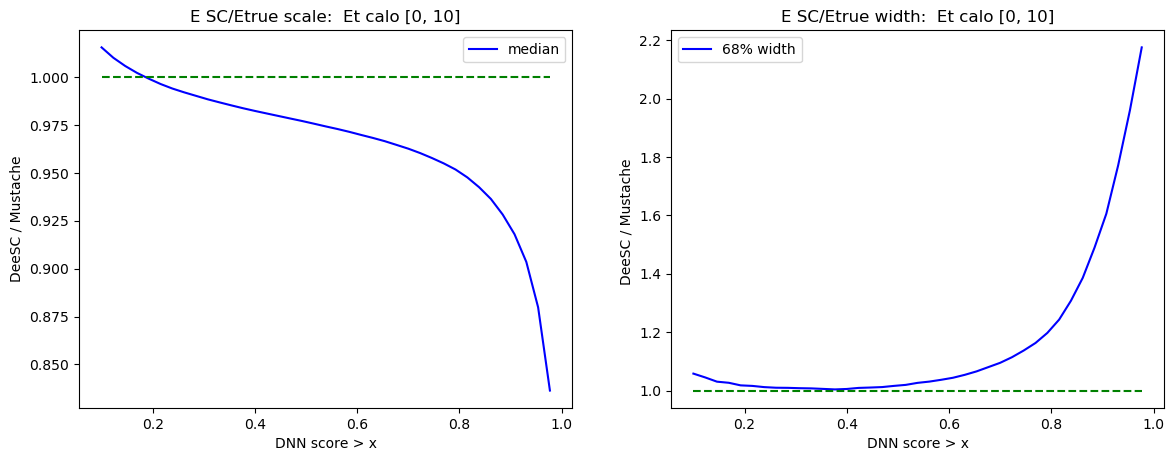

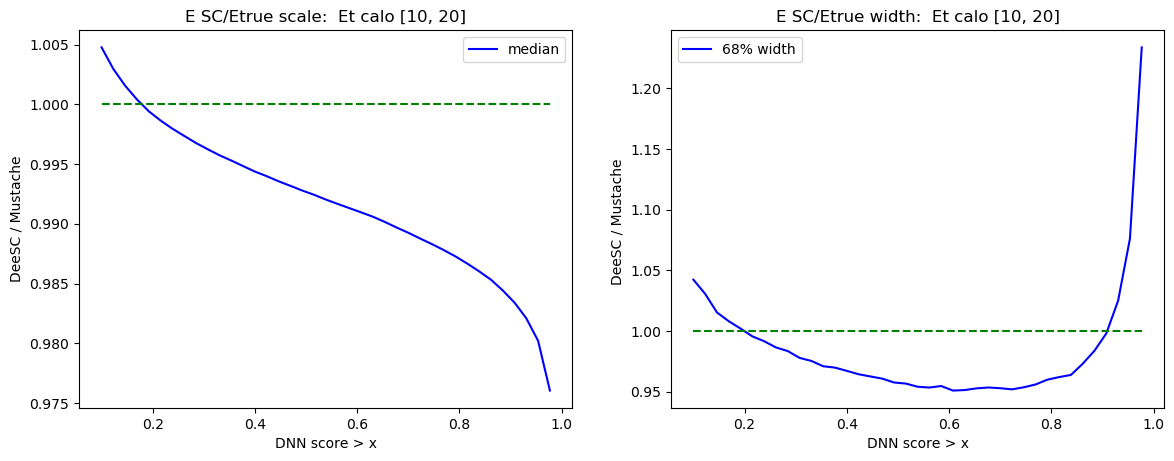

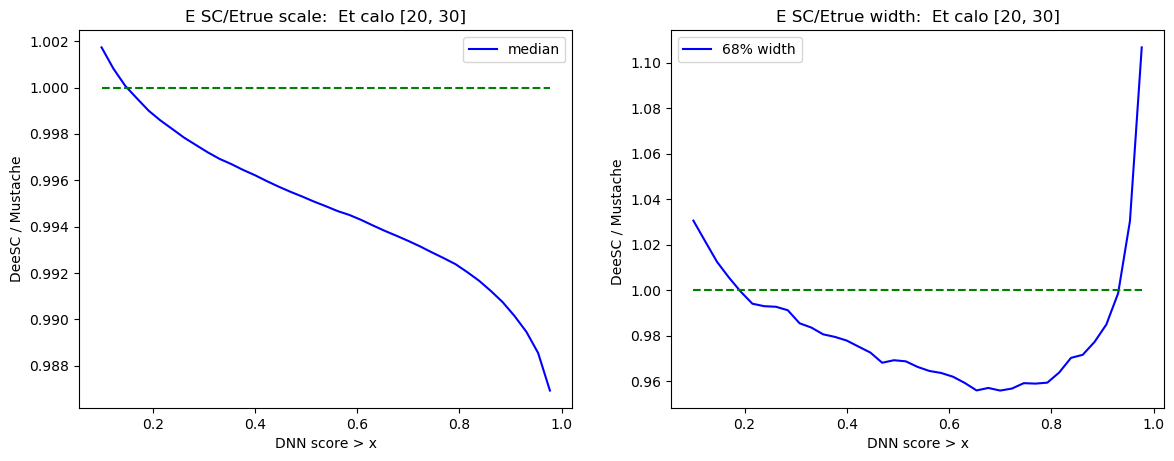

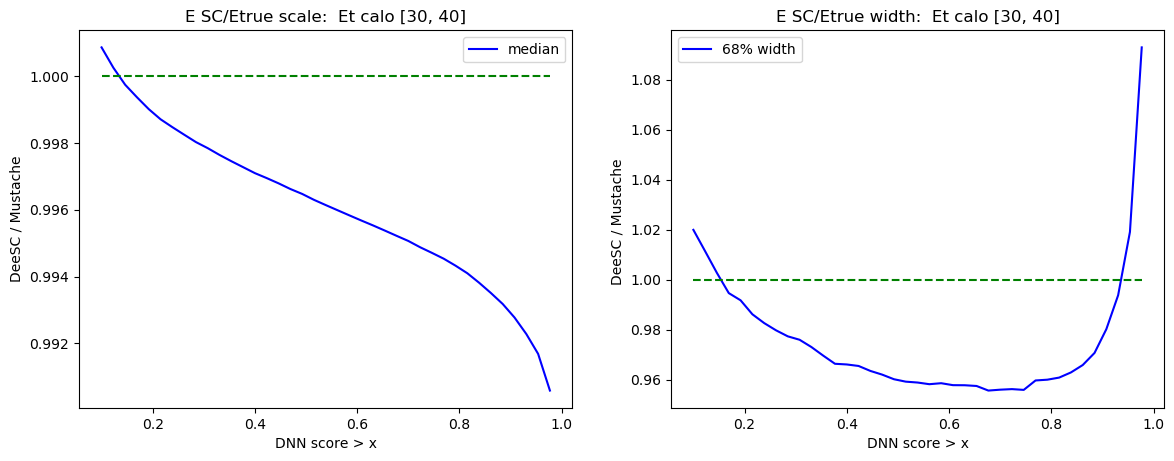

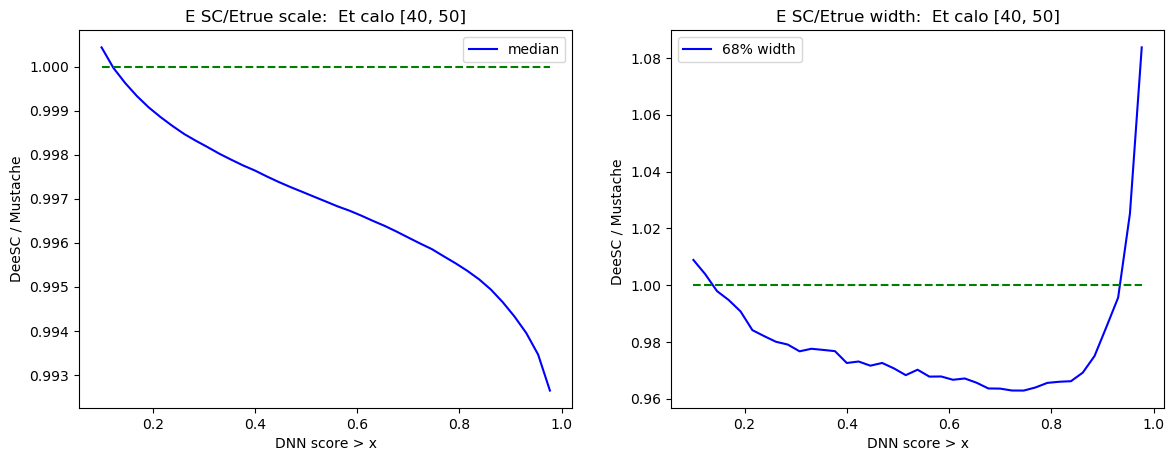

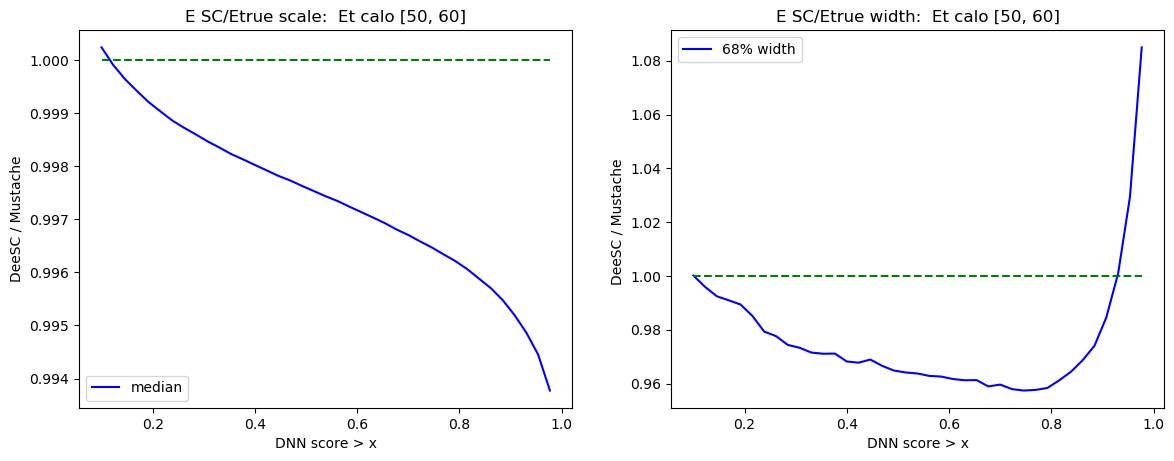

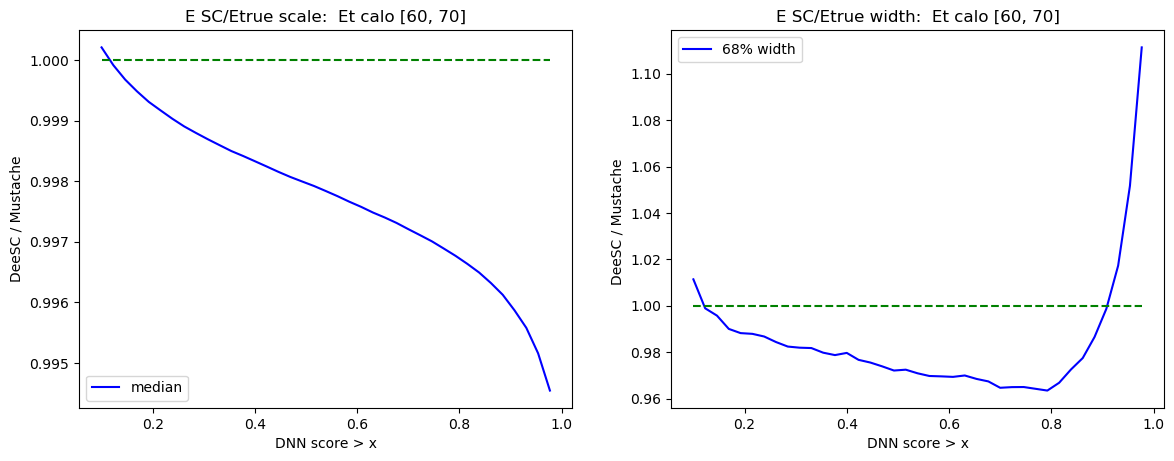

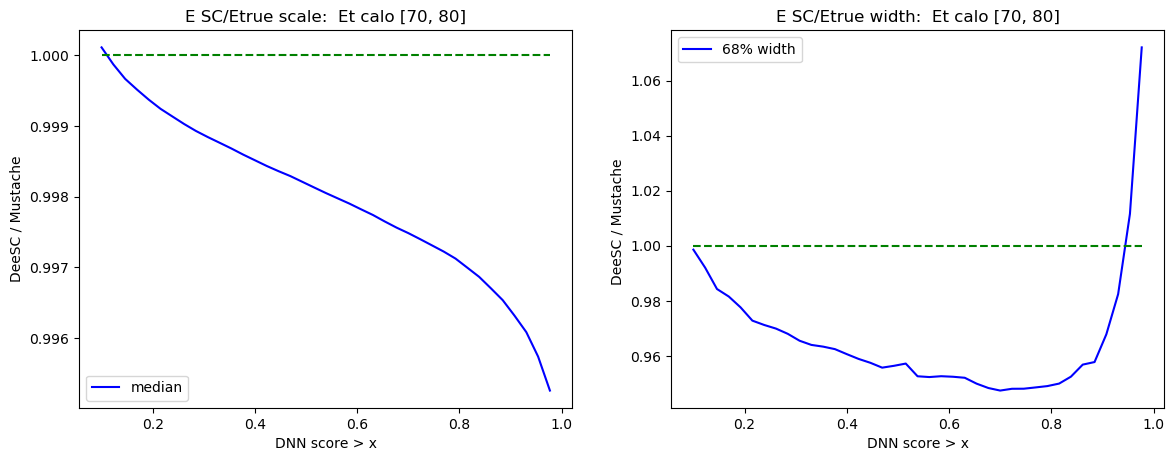

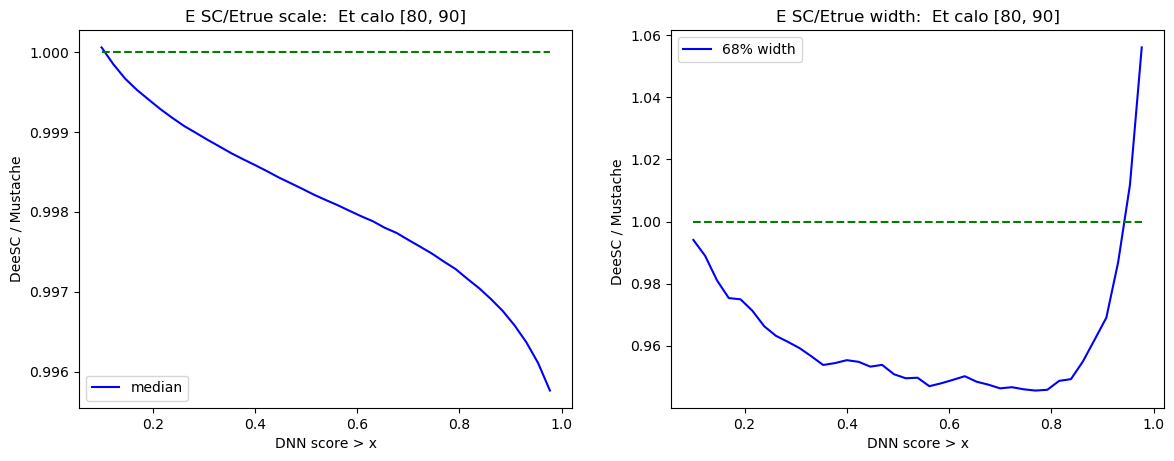

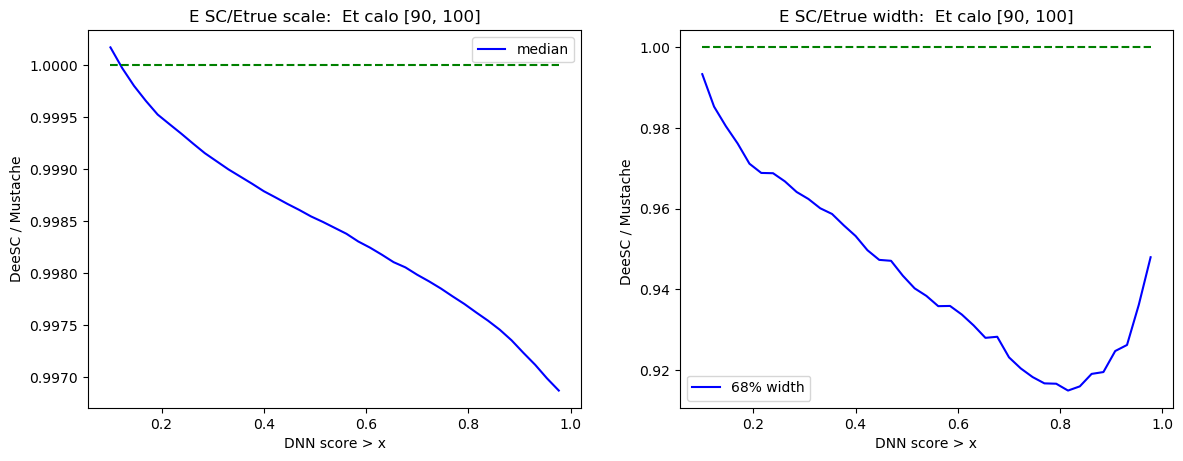

In [16]:
for enbin in range(len(ens)-1):
    
    fig, [ax1,ax2] = plt.subplots(1,2, figsize=(14,5), dpi=100)
    df = result_eb[(result_eb.en_bin==enbin)]
    x = df.dnn_thre.values
    
    # scale
    y = df["EoEtrue_68scale"].values
    y_must = result_eb_must[result_eb_must.en_bin==enbin]["EoEtrue_68scale"].iloc[0]
    ax1.plot(x, y/y_must, "b",label="median")
    ax1.plot(x, [1.]*len(x), "g--")
    #ax1.plot(x, [y_must]*len(x),"r", label= "Mustache 68% scale")
    
    #y = df["EoEtrue_scale"].values
    #y_must = result_eb_must[result_eb_must.en_bin==enbin]["EoEtrue_scale"].iloc[0]
    #ax1.plot(x, y/y_must, "r",label="scale")
    #ax1.plot(x, [y_must]*len(x),"r+", label="Mustache scale")
    
    ax1.legend()
    ax1.set_xlabel("DNN score > x")
    ax1.set_ylabel("DeeSC / Mustache")
    ax1.set_title(f"E SC/Etrue scale:  Et calo [{ens[enbin]}, {ens[enbin+1]}]")
    
    ##### width
    y = df["EoEtrue_68width"].values
    y_must = result_eb_must[result_eb_must.en_bin==enbin]["EoEtrue_68width"].iloc[0]
    
    ax2.plot(x, y/y_must,  "b", label="68% width",)
    ax2.plot(x, [1.]*len(x), "g--")
    #ax2.plot(x, [y_must]*len(x),  "r", label= "Mustache 68% width",)
    
    #y = df["EoEtrue_rms"].values
    #y_must = result_eb_must[result_eb_must.en_bin==enbin]["EoEtrue_rms"].iloc[0]
    #ax2.plot(x, y/y_must,  "r", label="rms width",)
    #ax3.plot(x, [y_must]*len(x), "r+", label="Mustache scale", )
    
    ax2.legend()
    ax2.set_xlabel("DNN score > x")
    ax2.set_ylabel("DeeSC / Mustache ")
    ax2.set_title(f"E SC/Etrue width:  Et calo [{ens[enbin]}, {ens[enbin+1]}]")
    
    fig.savefig(output_dir +f"barrel/scale_width_et_{ens[enbin]}_{ens[enbin+1]}_calo.png")
    

## Endcap

## By et seed

In [11]:
eta_range = [1.479,1.75]
ens = [ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
#ens= [0,1,2,3,5,8,10,20,100]
dnn_thres =  np.linspace(0.2 ,1, 40)[:-1]


results= []

for thr in dnn_thres:
    #print("DNN threshold: ", thr)
    g = data_val[(abs(data_val.seed_eta)>=eta_range[0]) & (abs(data_val.seed_eta)< eta_range[1]) &
                 ( (data_val.y >  thr) | (data_val.is_seed==True) ) ].groupby("window_index", sort=False).agg(
                            { "en_cluster": 'sum' ,
                              "en_true": "min", 
                              "et_seed": "first",
                              })
    #print(g)
    g["EoEtrue"] = g["en_cluster"] / g["en_true"]
    g["en_bin"] = pd.cut(g["et_seed"], ens, labels=list(range(len(ens)-1)))
    
    scanres = g.groupby("en_bin").apply(bin_analysis)
    scanres["dnn_thre"] = thr
    results.append(scanres)

result_ee = pd.concat(results)
#result.columns = ["_".join(col_name).rstrip('_') for col_name in result.columns.to_flat_index()]

# index by en_bin and DNN threshold
result_ee.reset_index(level=0, inplace=True)


g = data_val[(abs(data_val.seed_eta)>=eta_range[0]) & (abs(data_val.seed_eta)<eta_range[1]) &
             ( (data_val.in_mustache==True) | (data_val.is_seed==True)) ].groupby("window_index", sort=False).agg(
                        { "en_cluster": 'sum' ,
                              "en_true": "min", 
                              "et_seed": "first",
                              })
#print(g)
g["EoEtrue"] = g["en_cluster"] / g["en_true"]
g["en_bin"] = pd.cut(g["et_seed"], ens, labels=list(range(len(ens)-1)))

result_ee_must = g.groupby("en_bin").apply(bin_analysis)

result_ee_must.reset_index(level=0, inplace=True)

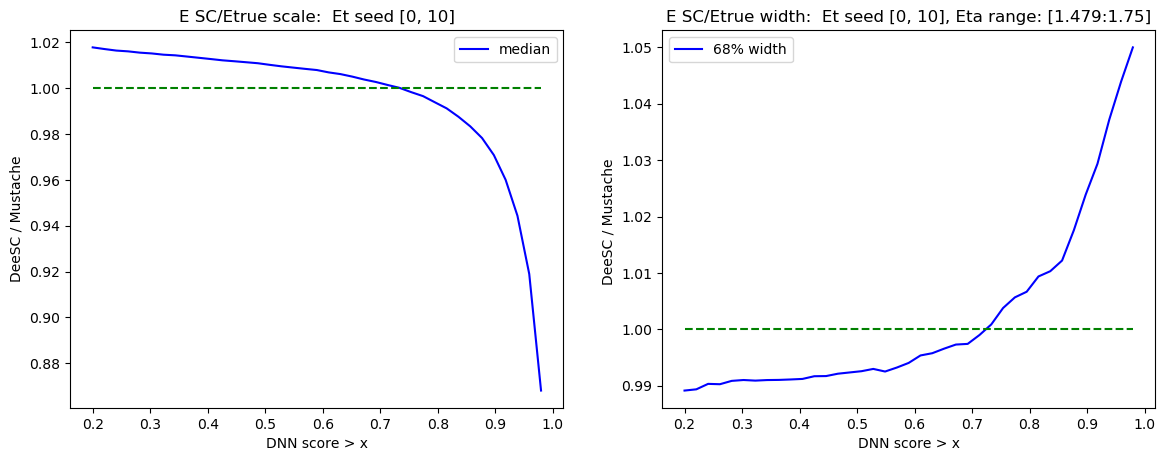

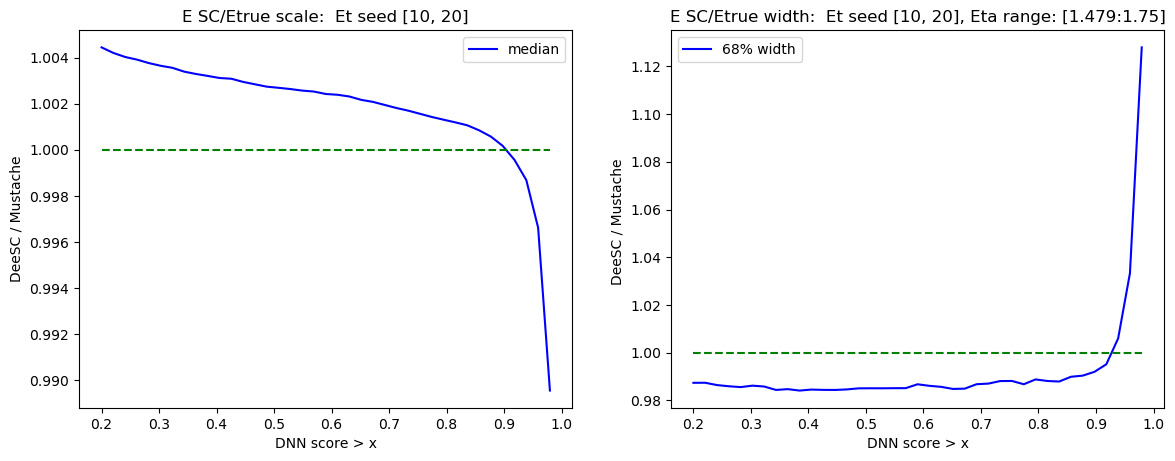

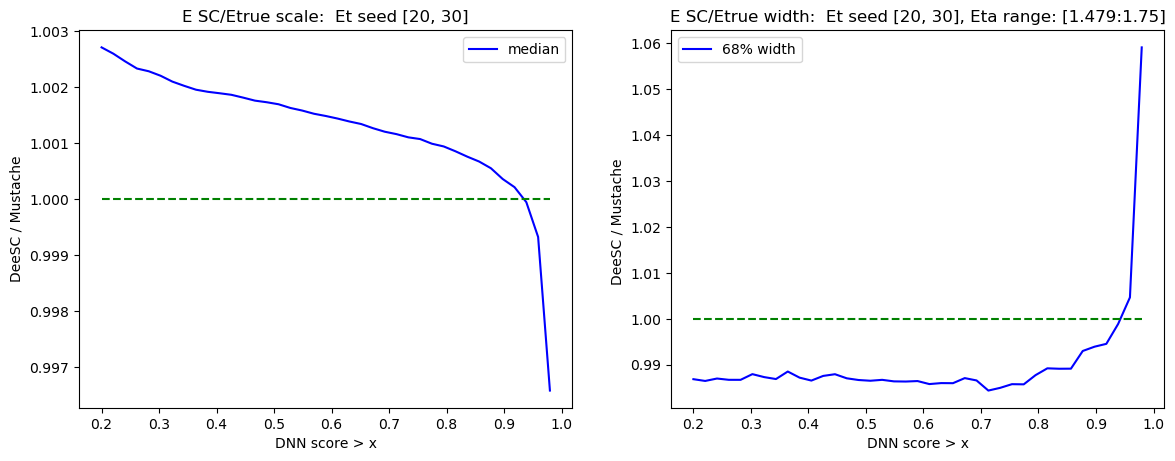

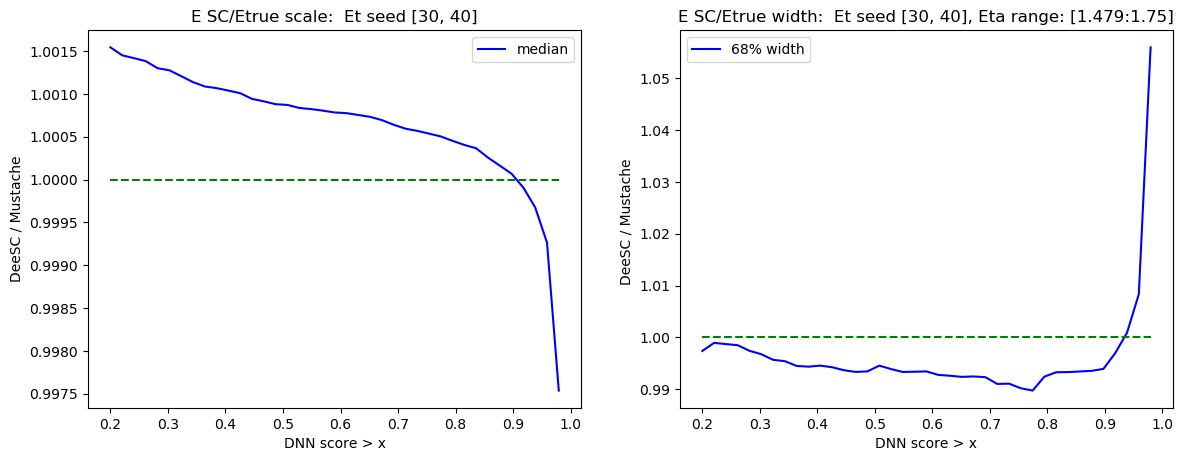

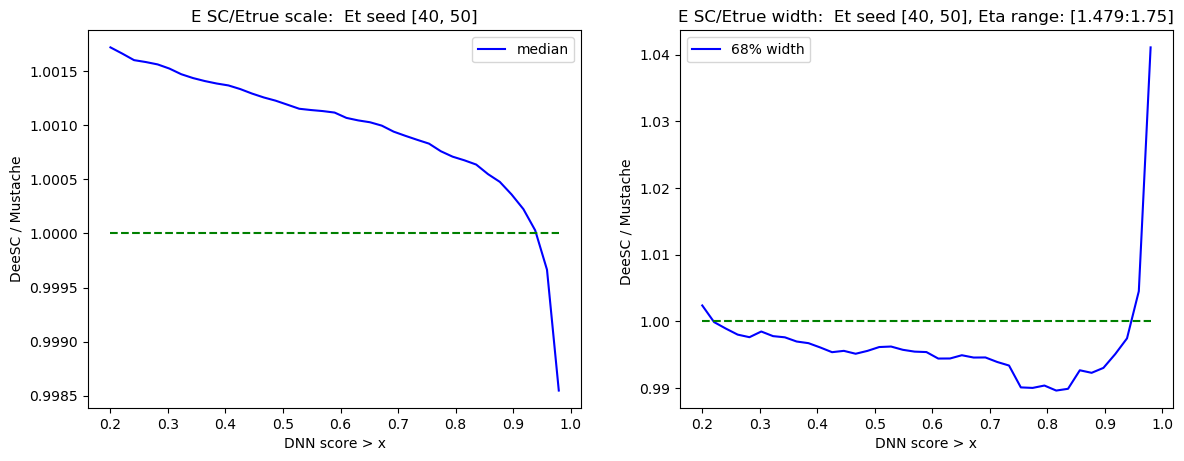

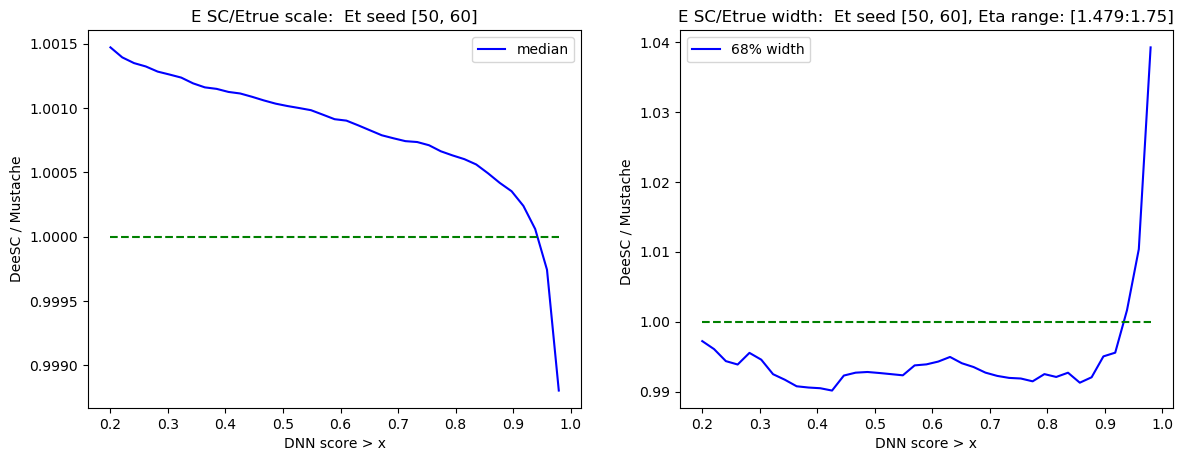

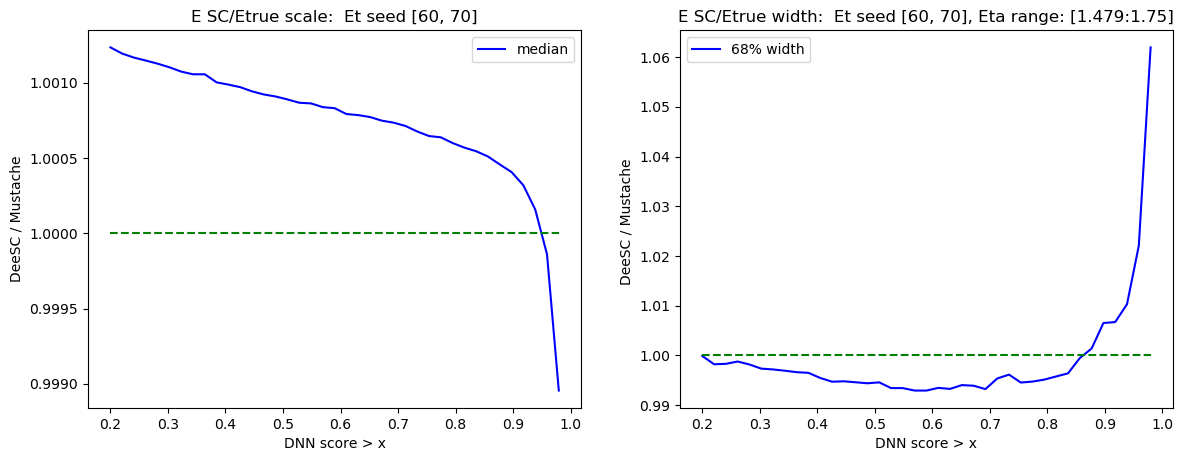

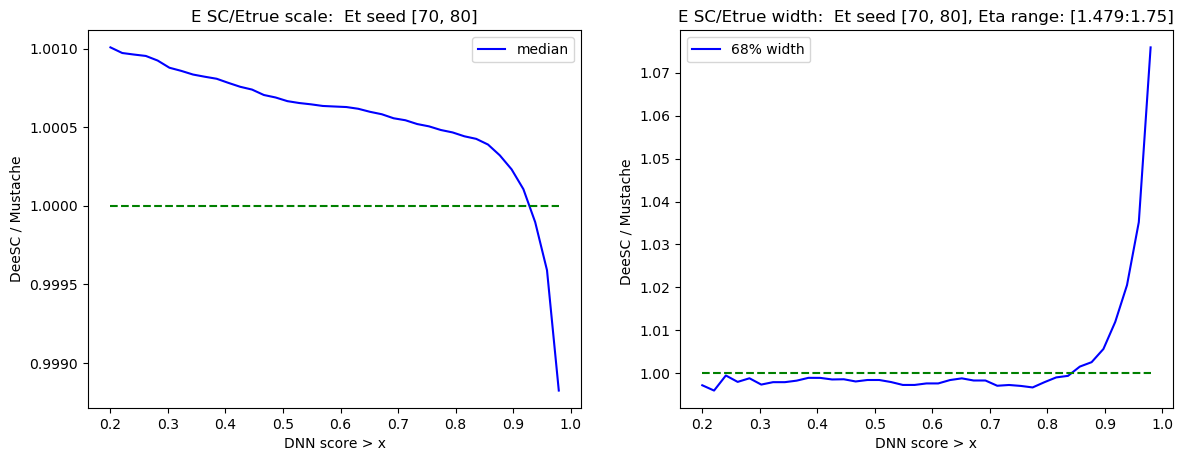

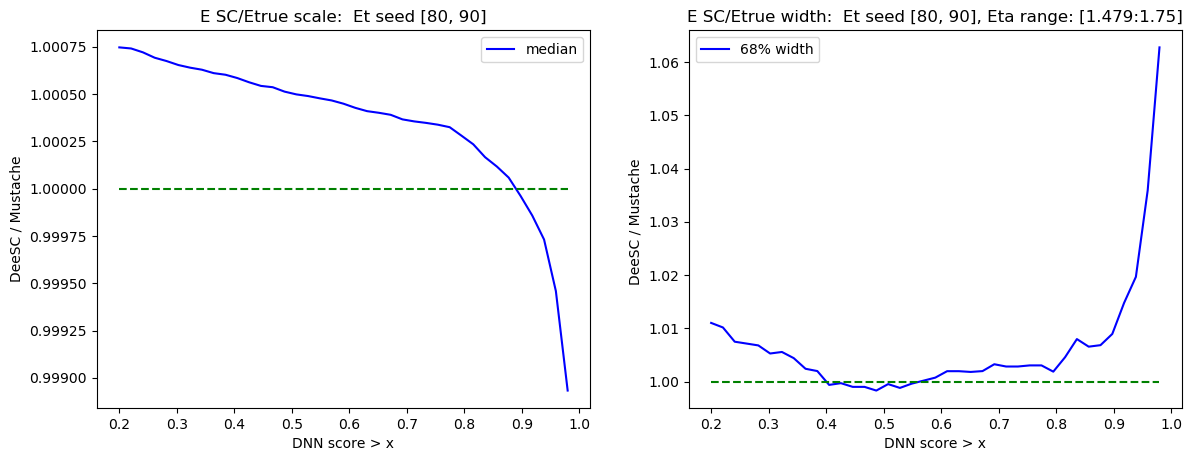

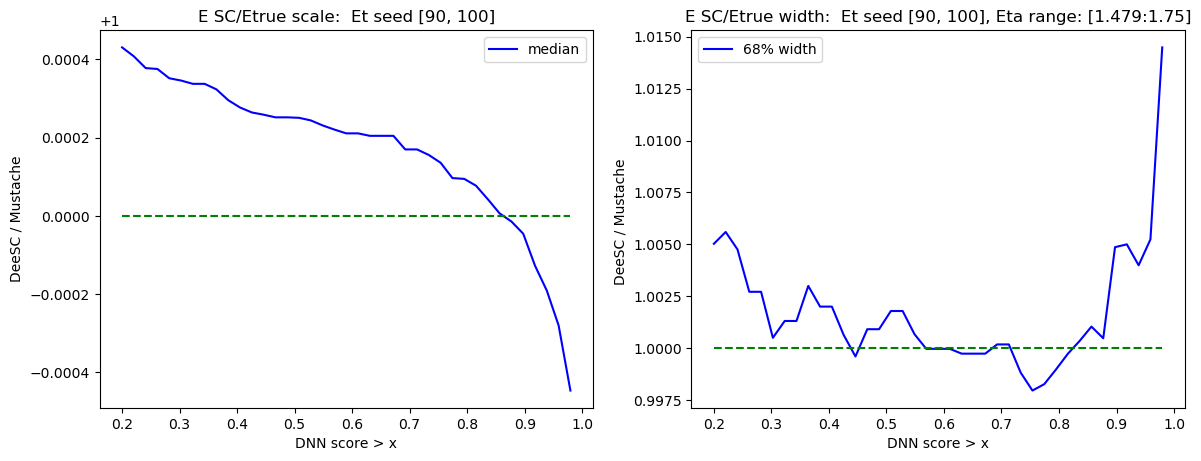

In [12]:
for enbin in range(len(ens)-1):
    
    fig, [ax1,ax2] = plt.subplots(1,2, figsize=(14,5), dpi=100)
    df = result_ee[(result_ee.en_bin==enbin)]
    x = df.dnn_thre.values
    
    # scale
    y = df["EoEtrue_68scale"].values
    y_must = result_ee_must[result_ee_must.en_bin==enbin]["EoEtrue_68scale"].iloc[0]
    ax1.plot(x, y/y_must, "b",label="median")
    ax1.plot(x, [1.]*len(x), "g--")
    #ax1.plot(x, [y_must]*len(x),"r", label= "Mustache 68% scale")
    
    #y = df["EoEtrue_scale"].values
    #y_must = result_eb_must[result_eb_must.en_bin==enbin]["EoEtrue_scale"].iloc[0]
    #ax1.plot(x, y/y_must, "r",label="scale")
    #ax1.plot(x, [y_must]*len(x),"r+", label="Mustache scale")
    
    ax1.legend()
    ax1.set_xlabel("DNN score > x")
    ax1.set_ylabel("DeeSC / Mustache")
    ax1.set_title(f"E SC/Etrue scale:  Et seed [{ens[enbin]}, {ens[enbin+1]}]")
    
    ##### width
    y = df["EoEtrue_68width"].values
    y_must = result_ee_must[result_ee_must.en_bin==enbin]["EoEtrue_68width"].iloc[0]
    
    ax2.plot(x, y/y_must,  "b", label="68% width",)
    ax2.plot(x, [1.]*len(x), "g--")
    #ax2.plot(x, [y_must]*len(x),  "r", label= "Mustache 68% width",)
    
    #y = df["EoEtrue_rms"].values
    #y_must = result_eb_must[result_eb_must.en_bin==enbin]["EoEtrue_rms"].iloc[0]
    #ax2.plot(x, y/y_must,  "r", label="rms width",)
    #ax3.plot(x, [y_must]*len(x), "r+", label="Mustache scale", )
    
    ax2.legend()
    ax2.set_xlabel("DNN score > x")
    ax2.set_ylabel("DeeSC / Mustache ")
    ax2.set_title(f"E SC/Etrue width:  Et seed [{ens[enbin]}, {ens[enbin+1]}], Eta range: [{eta_range[0]}:{eta_range[1]}]")
    
    fig.savefig(output_dir +f"endcap/scale_width_eta_{eta_range[0]}_{eta_range[1]}_et_{ens[enbin]}_{ens[enbin+1]}_seed.png")
    

## Et calo

In [35]:
eta_range = [1.75, 3]
ens = [ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
dnn_thres =  np.linspace(0.2 ,1, 40)[:-1]


results= []


for thr in dnn_thres:
    #print("DNN threshold: ", thr)
    g = data_val[(abs(data_val.seed_eta)>=eta_range[0]) & (abs(data_val.seed_eta)< eta_range[1]) &
                 ( (data_val.y >  thr) | (data_val.is_seed==True) ) ].groupby("window_index", sort=False).agg(
                            { "en_cluster": 'sum' ,
                              "en_true": "min", 
                              "et_true": "first",
                              })
    #print(g)
    g["EoEtrue"] = g["en_cluster"] / g["en_true"]
    g["en_bin"] = pd.cut(g["et_true"], ens, labels=list(range(len(ens)-1)))
    
    scanres = g.groupby("en_bin").apply(bin_analysis)
    scanres["dnn_thre"] = thr
    results.append(scanres)

result_ee = pd.concat(results)
#result.columns = ["_".join(col_name).rstrip('_') for col_name in result.columns.to_flat_index()]

# index by en_bin and DNN threshold
result_ee.reset_index(level=0, inplace=True)

g = data_val[(abs(data_val.seed_eta)>=eta_range[0]) & (abs(data_val.seed_eta)<eta_range[1]) &
             ( (data_val.in_mustache==True) | (data_val.is_seed==True)) ].groupby("window_index", sort=False).agg(
                        { "en_cluster": 'sum' ,
                              "en_true": "min", 
                              "et_true": "first",
                              })
#print(g)
g["EoEtrue"] = g["en_cluster"] / g["en_true"]
g["en_bin"] = pd.cut(g["et_true"], ens, labels=list(range(len(ens)-1)))

result_ee_must = g.groupby("en_bin").apply(bin_analysis)

result_ee_must.reset_index(level=0, inplace=True)

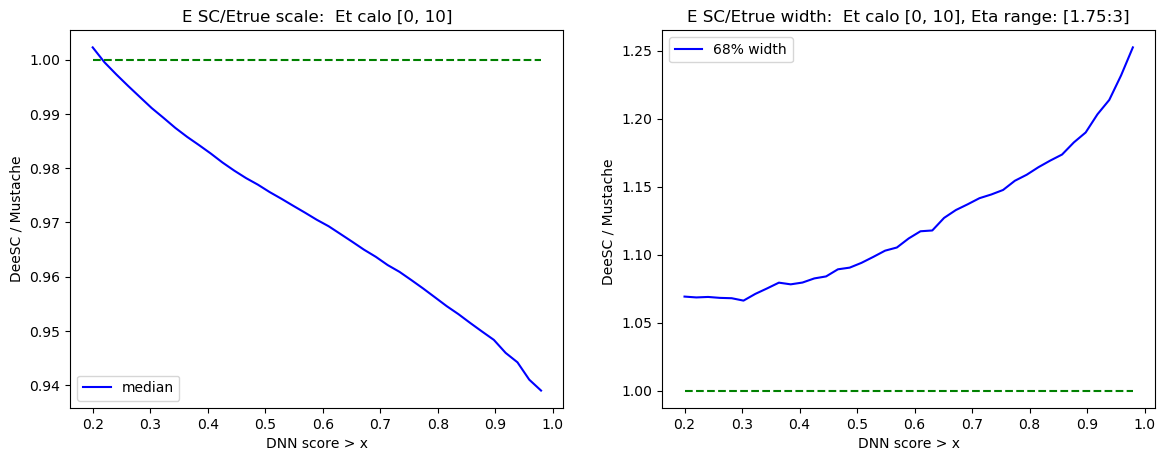

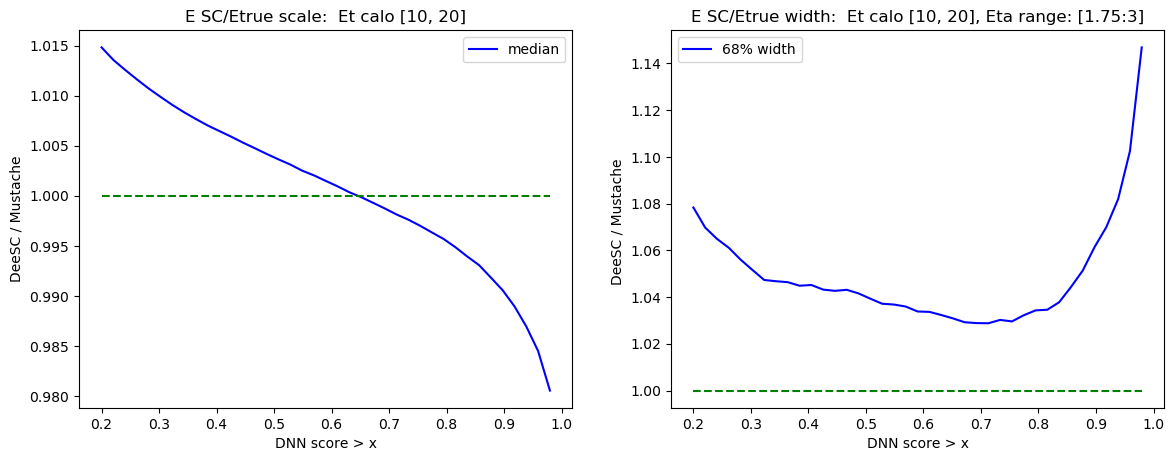

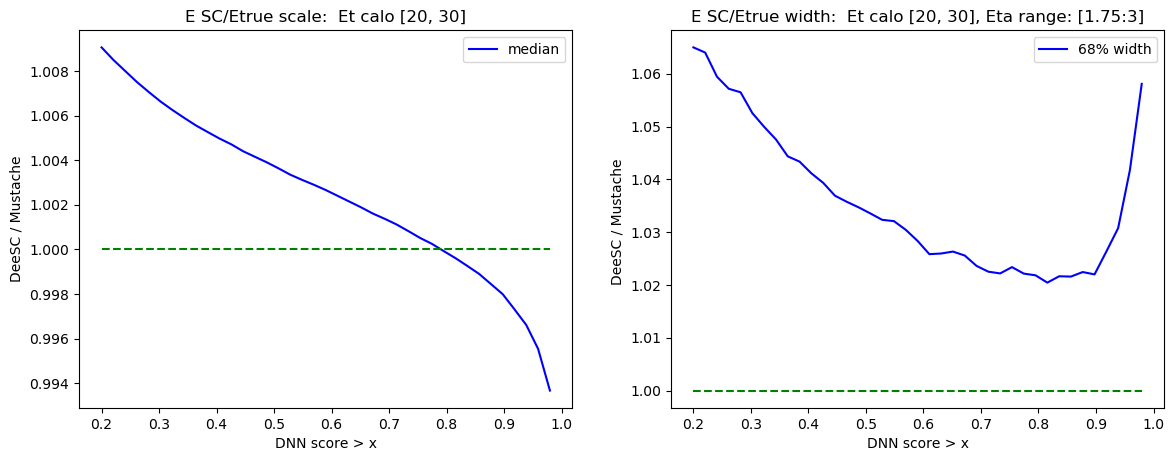

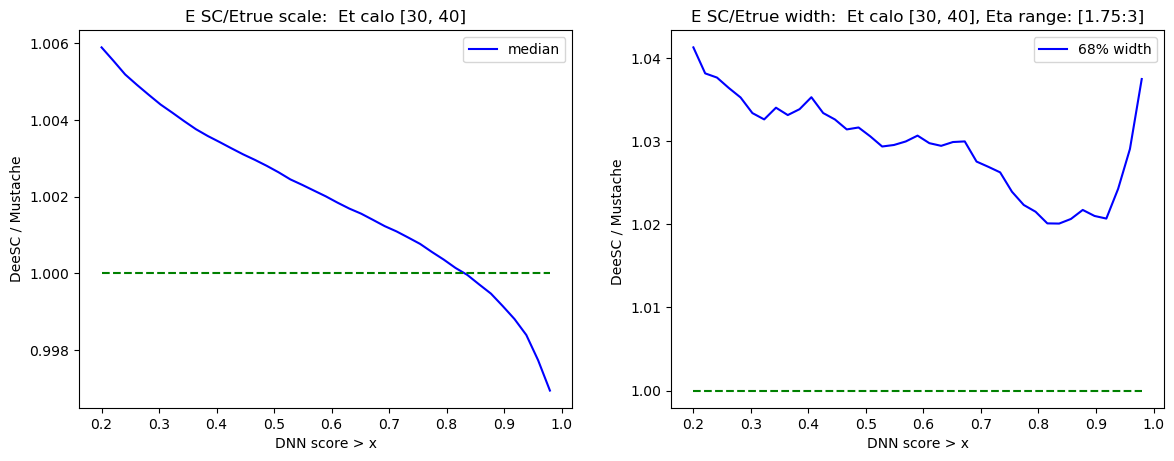

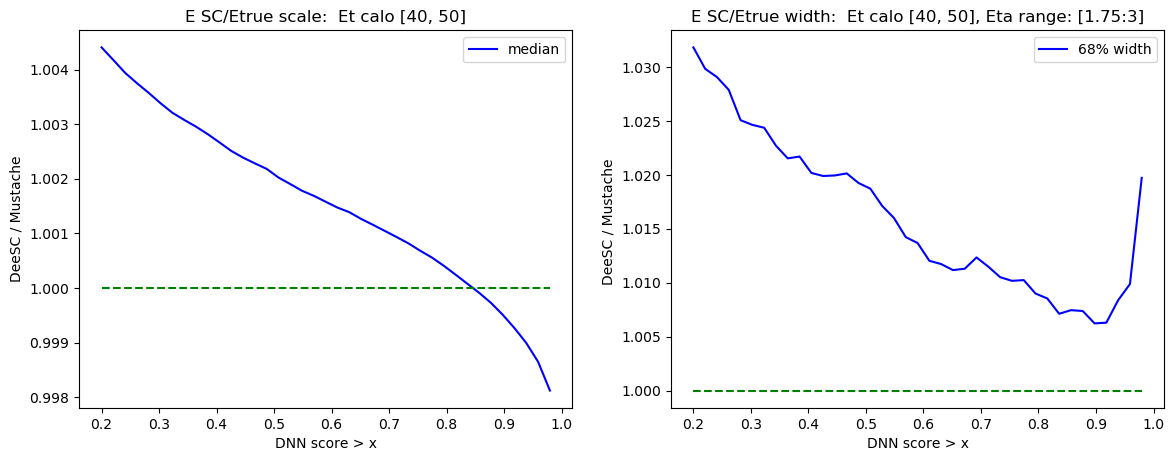

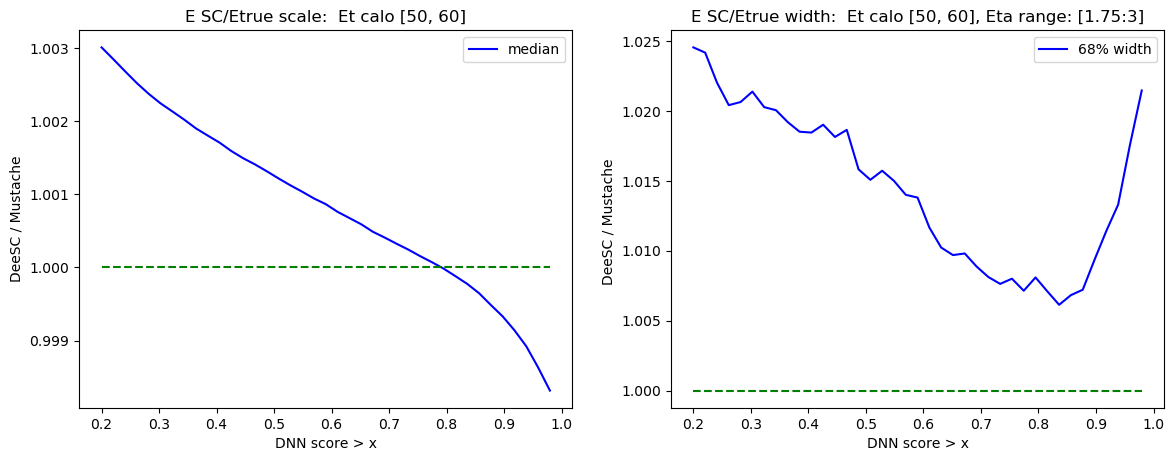

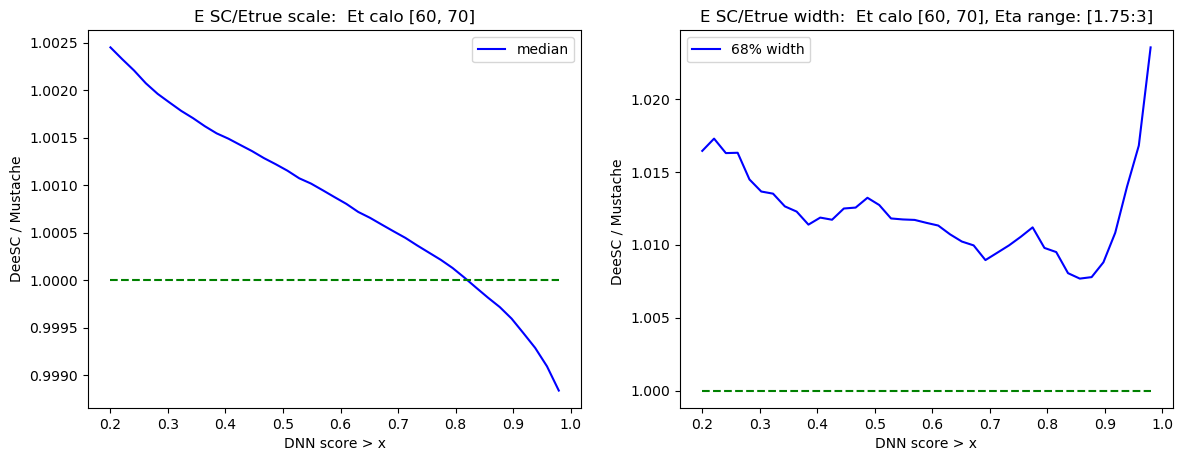

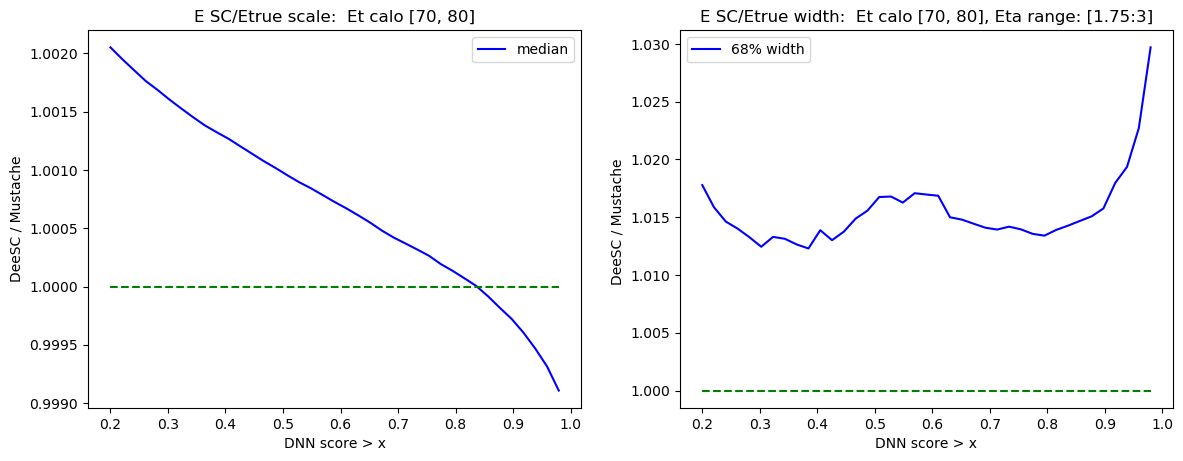

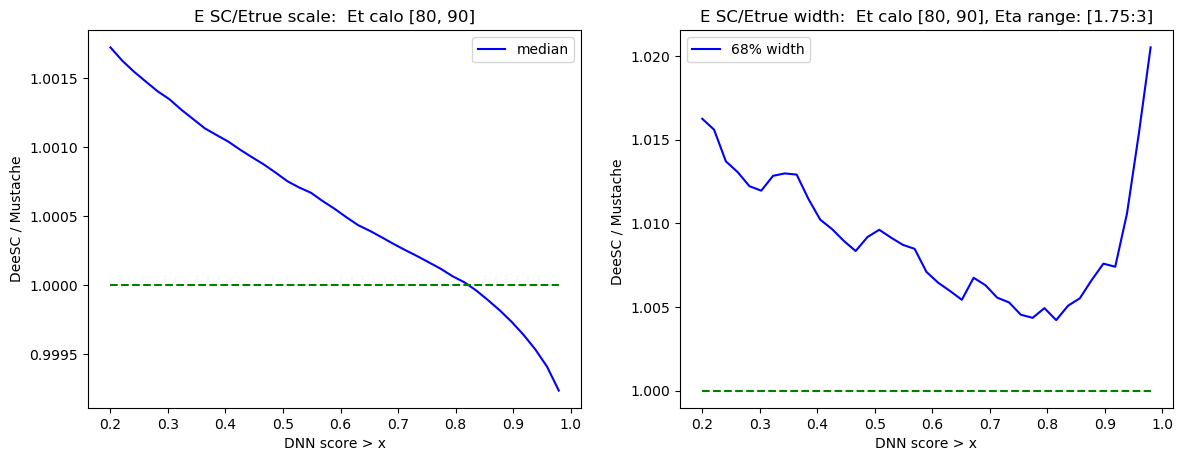

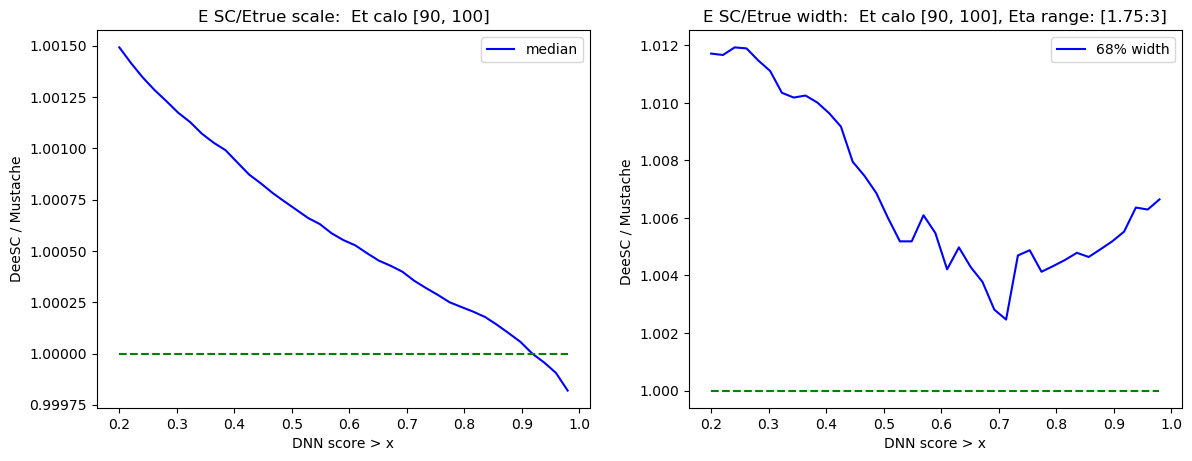

In [36]:
for enbin in range(len(ens)-1):
    
    fig, [ax1,ax2] = plt.subplots(1,2, figsize=(14,5), dpi=100)
    df = result_ee[(result_ee.en_bin==enbin)]
    x = df.dnn_thre.values
    
    # scale
    y = df["EoEtrue_68scale"].values
    y_must = result_ee_must[result_ee_must.en_bin==enbin]["EoEtrue_68scale"].iloc[0]
    ax1.plot(x, y/y_must, "b",label="median")
    ax1.plot(x, [1.]*len(x), "g--")
    #ax1.plot(x, [y_must]*len(x),"r", label= "Mustache 68% scale")
    
    #y = df["EoEtrue_scale"].values
    #y_must = result_eb_must[result_eb_must.en_bin==enbin]["EoEtrue_scale"].iloc[0]
    #ax1.plot(x, y/y_must, "r",label="scale")
    #ax1.plot(x, [y_must]*len(x),"r+", label="Mustache scale")
    
    ax1.legend()
    ax1.set_xlabel("DNN score > x")
    ax1.set_ylabel("DeeSC / Mustache")
    ax1.set_title(f"E SC/Etrue scale:  Et calo [{ens[enbin]}, {ens[enbin+1]}]")
    
    ##### width
    y = df["EoEtrue_68width"].values
    y_must = result_ee_must[result_ee_must.en_bin==enbin]["EoEtrue_68width"].iloc[0]
    
    ax2.plot(x, y/y_must,  "b", label="68% width",)
    ax2.plot(x, [1.]*len(x), "g--")
    #ax2.plot(x, [y_must]*len(x),  "r", label= "Mustache 68% width",)
    
    #y = df["EoEtrue_rms"].values
    #y_must = result_eb_must[result_eb_must.en_bin==enbin]["EoEtrue_rms"].iloc[0]
    #ax2.plot(x, y/y_must,  "r", label="rms width",)
    #ax3.plot(x, [y_must]*len(x), "r+", label="Mustache scale", )
    
    ax2.legend()
    ax2.set_xlabel("DNN score > x")
    ax2.set_ylabel("DeeSC / Mustache ")
    ax2.set_title(f"E SC/Etrue width:  Et calo [{ens[enbin]}, {ens[enbin+1]}], Eta range: [{eta_range[0]}:{eta_range[1]}]")
    
    fig.savefig(output_dir +f"endcap/scale_width_eta_{eta_range[0]}_{eta_range[1]}_et_{ens[enbin]}_{ens[enbin+1]}_calo.png")
    

# Signal and bkg efficiencies by $\eta$ and Pt


In [15]:
etas = [0, 0.2, 0.4 ,0.6, 0.8, 1, 1.2, 1.4, 1.479, 1.75, 2, 2.25, 3]
ens = [ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
#etas = [0, 1, 2]
#ens= [0, 50, 100]
threshold = 0.88

results = np.zeros((len(etas)-1, len(ens)-1, 2))

data_in = data_in[data_in.is_seed==False]
data_out = data_out[data_out.is_seed==False]

y = "y"

for ieta in range(len(etas)-1):
    for ien in range(len(ens)-1):
        eta_min = etas[ieta]
        eta_max = etas[ieta+1]
        et_min = ens[ien]
        et_max = ens[ien+1]
        print(eta_min, eta_max, et_min, et_max)
        
        data_out_tot = data_out[(abs(data_out.seed_eta) > eta_min) & (abs(data_out.seed_eta) < eta_max) &
                            (data_out.en_seed / np.cosh(data_out.seed_eta)  > et_min) & (data_out.en_seed / np.cosh(data_out.seed_eta) < et_max) ].size
        data_out_1 = data_out[(data_out[y] > threshold) & (abs(data_out.seed_eta) > eta_min) & (abs(data_out.seed_eta) < eta_max) &
                            (data_out.en_seed / np.cosh(data_out.seed_eta)  > et_min) & (data_out.en_seed / np.cosh(data_out.seed_eta) < et_max) ].size
        data_in_tot = data_in[ (abs(data_in.seed_eta) > eta_min) & (abs(data_in.seed_eta) < eta_max) &
                            (data_in.en_seed / np.cosh(data_in.seed_eta)  > et_min) & (data_in.en_seed / np.cosh(data_in.seed_eta) < et_max) ].size
        data_in_1 = data_in[(data_in[y] > threshold) & (abs(data_in.seed_eta) > eta_min) & (abs(data_in.seed_eta) < eta_max) &
                            (data_in.en_seed / np.cosh(data_in.seed_eta)  > et_min) & (data_in.en_seed / np.cosh(data_in.seed_eta) < et_max) ].size
        
        results[ieta, ien, :] = np.array([data_in_1 / data_in_tot , data_out_1 / data_out_tot])

0 0.2 0 10
0 0.2 10 20
0 0.2 20 30
0 0.2 30 40
0 0.2 40 50
0 0.2 50 60
0 0.2 60 70
0 0.2 70 80
0 0.2 80 90
0 0.2 90 100
0.2 0.4 0 10
0.2 0.4 10 20
0.2 0.4 20 30
0.2 0.4 30 40
0.2 0.4 40 50
0.2 0.4 50 60
0.2 0.4 60 70
0.2 0.4 70 80
0.2 0.4 80 90
0.2 0.4 90 100
0.4 0.6 0 10
0.4 0.6 10 20
0.4 0.6 20 30
0.4 0.6 30 40
0.4 0.6 40 50
0.4 0.6 50 60
0.4 0.6 60 70
0.4 0.6 70 80
0.4 0.6 80 90
0.4 0.6 90 100
0.6 0.8 0 10
0.6 0.8 10 20
0.6 0.8 20 30
0.6 0.8 30 40
0.6 0.8 40 50
0.6 0.8 50 60
0.6 0.8 60 70
0.6 0.8 70 80
0.6 0.8 80 90
0.6 0.8 90 100
0.8 1 0 10
0.8 1 10 20
0.8 1 20 30
0.8 1 30 40
0.8 1 40 50
0.8 1 50 60
0.8 1 60 70
0.8 1 70 80
0.8 1 80 90
0.8 1 90 100
1 1.2 0 10
1 1.2 10 20
1 1.2 20 30
1 1.2 30 40
1 1.2 40 50
1 1.2 50 60
1 1.2 60 70
1 1.2 70 80
1 1.2 80 90
1 1.2 90 100
1.2 1.4 0 10
1.2 1.4 10 20
1.2 1.4 20 30
1.2 1.4 30 40
1.2 1.4 40 50
1.2 1.4 50 60
1.2 1.4 60 70
1.2 1.4 70 80
1.2 1.4 80 90
1.2 1.4 90 100
1.4 1.479 0 10
1.4 1.479 10 20
1.4 1.479 20 30
1.4 1.479 30 40
1.4 1.479 40 50
1

Text(0.55, 0.92, 'Wrong cluster selection eff.')

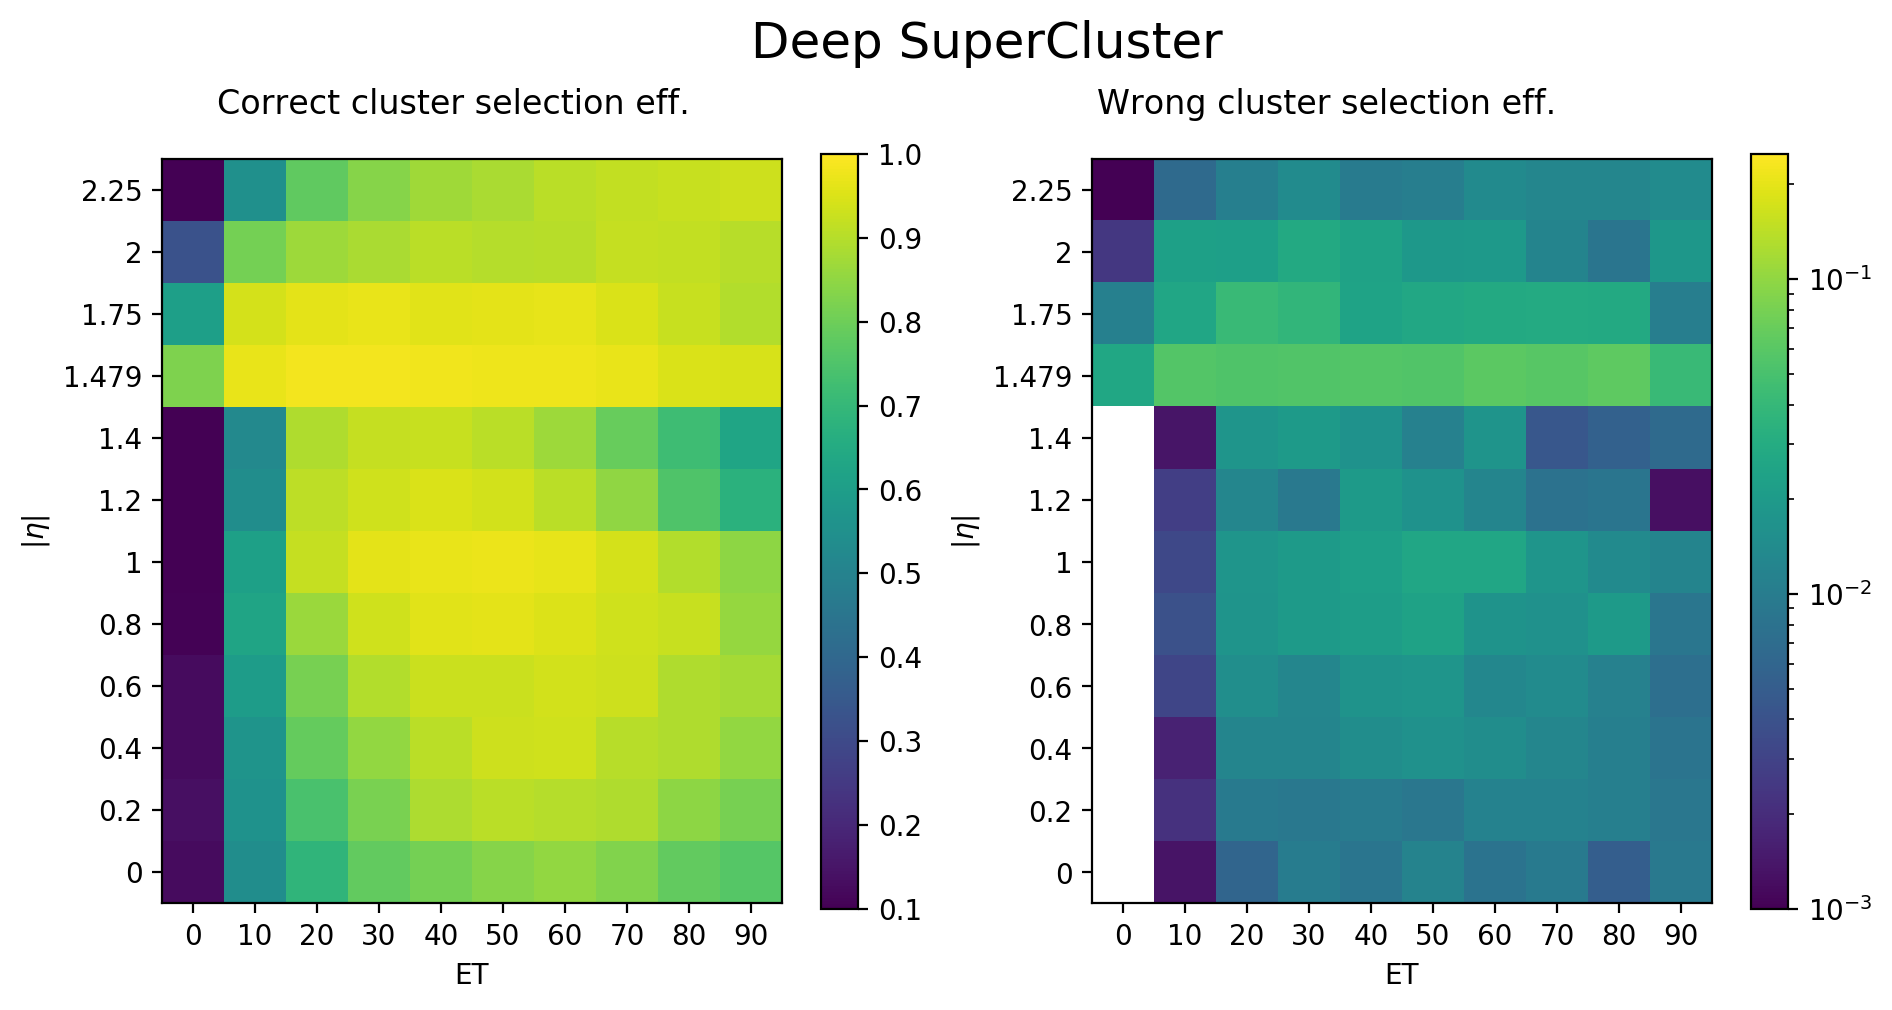

In [16]:
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(11,5), dpi=200)
im = ax1.imshow(results[:,:,0], vmax=1, vmin=0.1)
ax1.set_xticks(np.arange(len(ens)-1))
ax1.set_yticks(np.arange(len(etas)-1))
ax1.set_yticklabels(etas)
ax1.set_xticklabels(ens)
ax1.set_xlabel("ET")
ax1.set_ylabel("$|\eta|$")
fig.colorbar(im, ax=ax1)

im2 = ax2.imshow(results[:,:,1], norm=colors.LogNorm(), vmax=2.5e-1, vmin=1e-3)
ax2.set_xticks(np.arange(len(ens)-1))
ax2.set_yticks(np.arange(len(etas)-1))
ax2.set_yticklabels(etas)
ax2.set_xticklabels(ens)
ax2.set_xlabel("ET")
ax2.set_ylabel("$|\eta|$")
fig.colorbar(im2, ax=ax2)


fig.text(0.5, 0.99, "Deep SuperCluster", ha="center", va="center", fontsize=18)
fig.text(0.15, 0.92, "Correct cluster selection eff.", fontsize=12)
fig.text(0.55, 0.92, "Wrong cluster selection eff.", fontsize=12)

plot


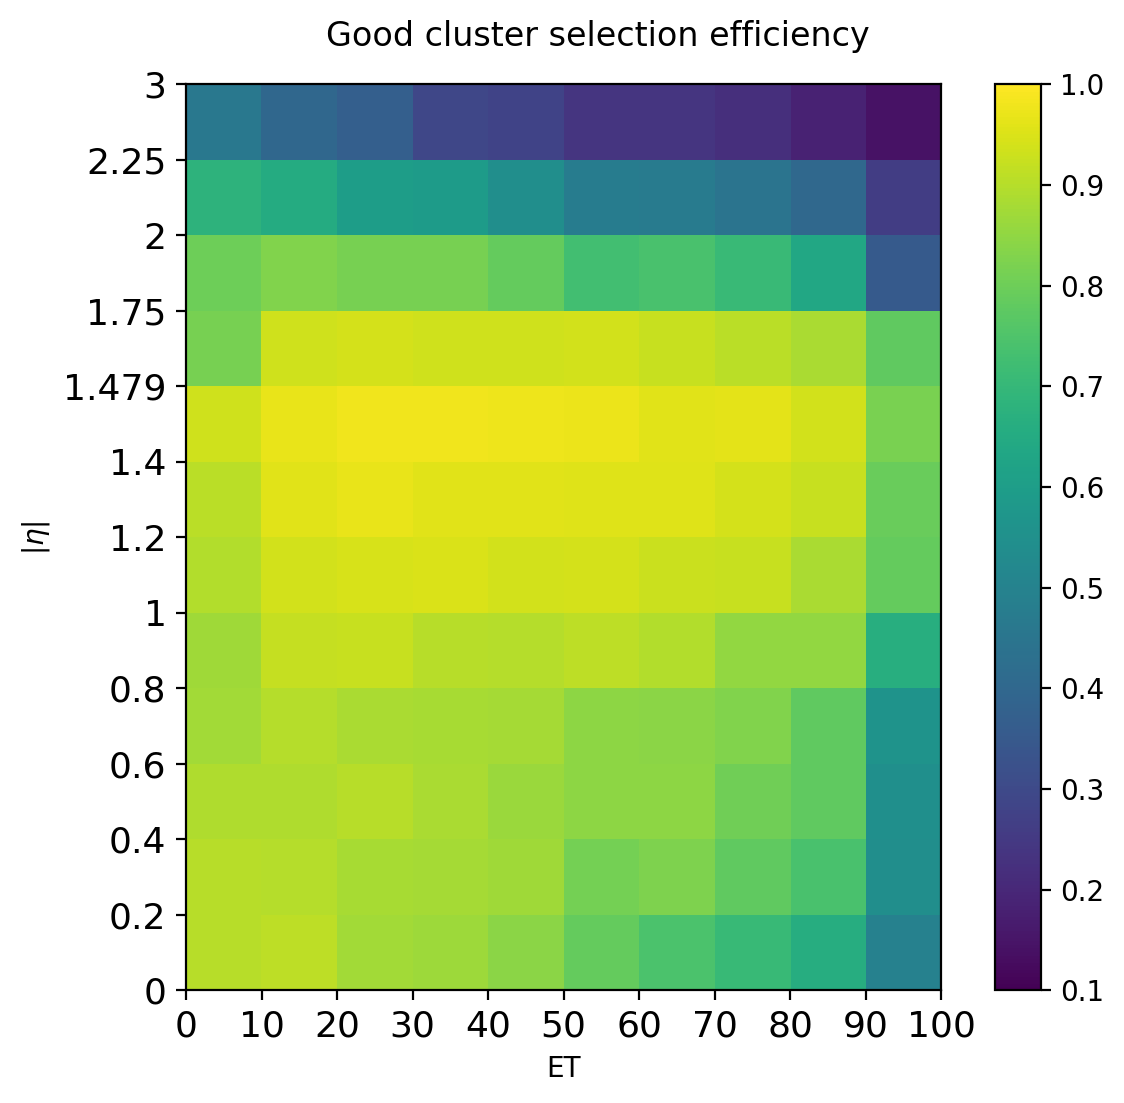

In [44]:
fig,ax1 = plt.subplots(figsize=(7,6), dpi=200)
im = ax1.imshow(results[:,:,0], vmax=1, vmin=0.1)
ax1.set_xticks(np.arange(len(ens)-1))
ax1.set_yticks(np.arange(len(etas)-1))
ax1.set_yticklabels(etas)
ax1.set_xticklabels(ens)
ax1.set_xlabel("ET")
ax1.set_ylabel("$|\eta|$")
fig.colorbar(im, ax=ax1)

locs, labels= plt.xticks()
labels.append("100")
locs = np.append(locs, [10])
plt.xticks(locs-0.5, labels)

locs, labels= plt.yticks()
labels.append("3")
locs = np.append(locs, locs[-1]+1)
plt.yticks(locs-0.5, labels)

fig.text(0.5, 0.92, "Good cluster selection efficiency", fontsize=12, va="center", ha="center")

plt.setp(ax1.get_xticklabels(), fontsize=13)
plt.setp(ax1.get_yticklabels(), fontsize=13)
print("plot")

([<matplotlib.axis.YTick at 0x7f2cef61d588>,
 <a list of 13 Text yticklabel objects>)

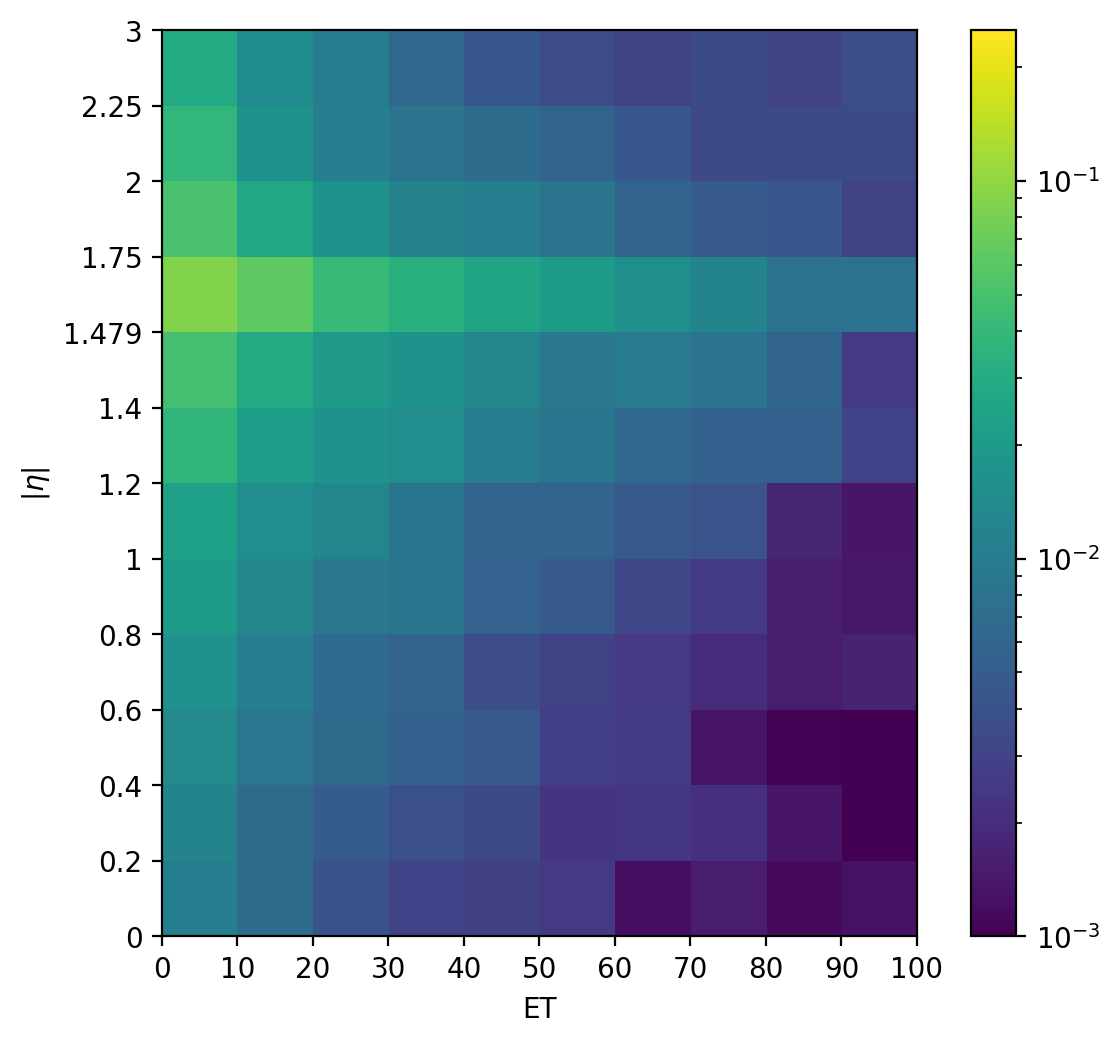

In [50]:
fig,ax1 = plt.subplots(figsize=(7,6), dpi=200)
im = ax1.imshow(results[:,:,1], norm=colors.LogNorm(), vmax=2.5e-1 , vmin=1e-3)
ax1.set_xticks(np.arange(len(ens)-1))
ax1.set_yticks(np.arange(len(etas)-1))
ax1.set_yticklabels(etas)
ax1.set_xticklabels(ens)
ax1.set_xlabel("ET")
ax1.set_ylabel("$|\eta|$")
fig.colorbar(im, ax=ax1)

locs, labels= plt.xticks()
labels.append("100")
locs = np.append(locs, [10])
plt.xticks(locs-0.5, labels)

locs, labels= plt.yticks()
labels.append("3")
locs = np.append(locs, locs[-1]+1)
plt.yticks(locs-0.5, labels)


### Signal and background eff mustache

In [ ]:
etas = [0, 0.2, 0.4 ,0.6, 0.8, 1, 1.2, 1.4, 1.479, 1.75, 2, 2.25, 3]
ens = [ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
#etas = [0, 1, 2]
#ens= [0, 50, 100]

results = np.zeros((len(etas)-1, len(ens)-1, 2))


for ieta in range(len(etas)-1):
    for ien in range(len(ens)-1):
        eta_min = etas[ieta]
        eta_max = etas[ieta+1]
        et_min = ens[ien]
        et_max = ens[ien+1]
        print(eta_min, eta_max, et_min, et_max)
        
        data_out_tot = F_must[(abs(F_must.seed_eta) > eta_min) & (abs(F_must.seed_eta) < eta_max) &
                            (F_must.en_seed / np.cosh(F_must.seed_eta)  > et_min) & (F_must.en_seed / np.cosh(F_must.seed_eta) < et_max) ].size
        data_out_1 = FP_must[(abs(FP_must.seed_eta) > eta_min) & (abs(FP_must.seed_eta) < eta_max) &
                            (FP_must.en_seed / np.cosh(FP_must.seed_eta)  > et_min) & (FP_must.en_seed / np.cosh(FP_must.seed_eta) < et_max) ].size
        data_in_tot = T_must[ (abs(T_must.seed_eta) > eta_min) & (abs(T_must.seed_eta) < eta_max) &
                            (T_must.en_seed / np.cosh(T_must.seed_eta)  > et_min) & (T_must.en_seed / np.cosh(T_must.seed_eta) < et_max) ].size
        data_in_1 = TP_must[(abs(TP_must.seed_eta) > eta_min) & (abs(TP_must.seed_eta) < eta_max) &
                            (TP_must.en_seed / np.cosh(TP_must.seed_eta)  > et_min) & (TP_must.en_seed / np.cosh(TP_must.seed_eta) < et_max) ].size
        
        results[ieta, ien, :] = np.array([data_in_1 / data_in_tot , data_out_1 / data_out_tot])

0 0.2 0 10
0 0.2 10 20
0 0.2 20 30
0 0.2 30 40
0 0.2 40 50
0 0.2 50 60
0 0.2 60 70
0 0.2 70 80
0 0.2 80 90
0 0.2 90 100
0.2 0.4 0 10
0.2 0.4 10 20
0.2 0.4 20 30
0.2 0.4 30 40
0.2 0.4 40 50
0.2 0.4 50 60
0.2 0.4 60 70
0.2 0.4 70 80
0.2 0.4 80 90
0.2 0.4 90 100
0.4 0.6 0 10
0.4 0.6 10 20
0.4 0.6 20 30
0.4 0.6 30 40
0.4 0.6 40 50
0.4 0.6 50 60
0.4 0.6 60 70
0.4 0.6 70 80
0.4 0.6 80 90
0.4 0.6 90 100
0.6 0.8 0 10
0.6 0.8 10 20
0.6 0.8 20 30
0.6 0.8 30 40
0.6 0.8 40 50
0.6 0.8 50 60
0.6 0.8 60 70
0.6 0.8 70 80
0.6 0.8 80 90
0.6 0.8 90 100
0.8 1 0 10
0.8 1 10 20
0.8 1 20 30
0.8 1 30 40
0.8 1 40 50
0.8 1 50 60
0.8 1 60 70
0.8 1 70 80
0.8 1 80 90
0.8 1 90 100
1 1.2 0 10
1 1.2 10 20
1 1.2 20 30
1 1.2 30 40
1 1.2 40 50
1 1.2 50 60
1 1.2 60 70
1 1.2 70 80
1 1.2 80 90
1 1.2 90 100
1.2 1.4 0 10
1.2 1.4 10 20


Text(0.55, 0.92, 'Wrong cluster selection eff.')

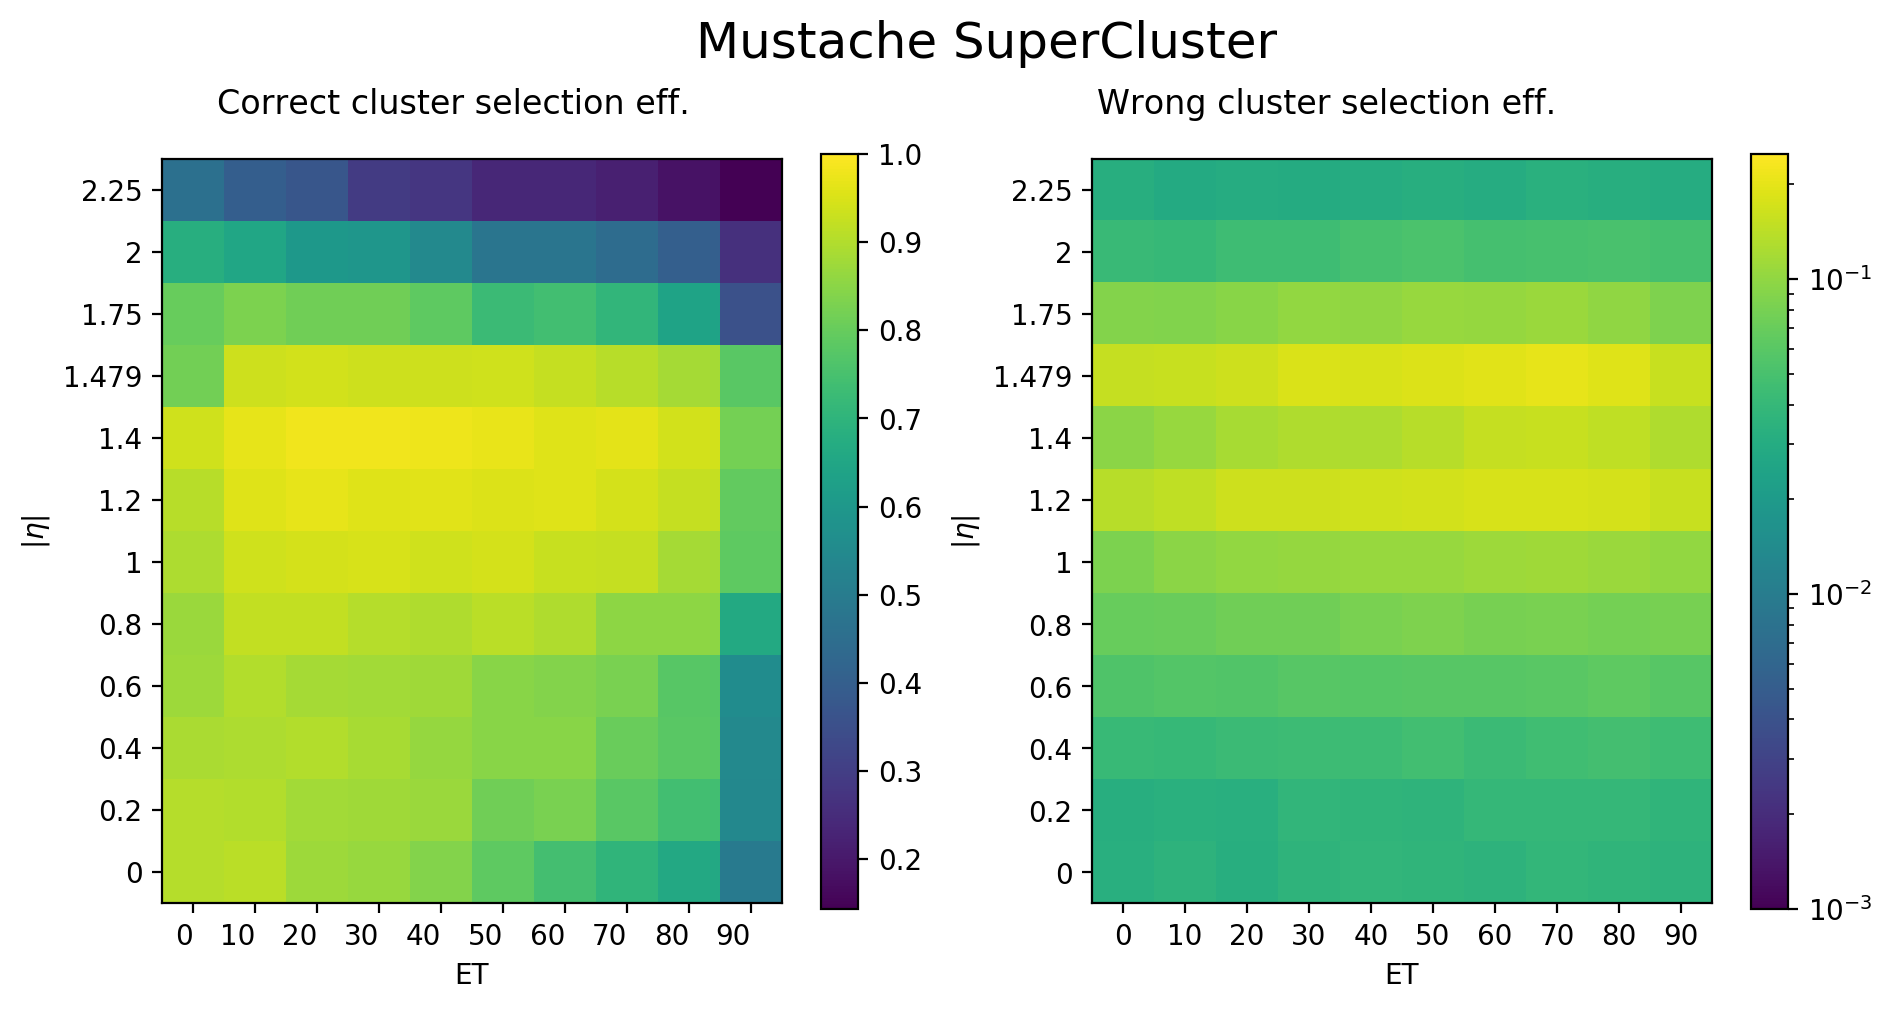

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(11,5), dpi=200)
im = ax1.imshow(results[:,:,0], vmax=1)
ax1.set_xticks(np.arange(len(ens)-1))
ax1.set_yticks(np.arange(len(etas)-1))
ax1.set_yticklabels(etas)
ax1.set_xticklabels(ens)
ax1.set_xlabel("ET")
ax1.set_ylabel("$|\eta|$")
fig.colorbar(im, ax=ax1)

im2 = ax2.imshow(results[:,:,1], norm=colors.LogNorm(), vmax=2.5e-1, vmin=1e-3)
ax2.set_xticks(np.arange(len(ens)-1))
ax2.set_yticks(np.arange(len(etas)-1))
ax2.set_yticklabels(etas)
ax2.set_xticklabels(ens)
ax2.set_xlabel("ET")
ax2.set_ylabel("$|\eta|$")
fig.colorbar(im2, ax=ax2)

plt.setp(ax1.xaxis.get_majorticklabels(), ha='right')


fig.text(0.5, 0.99, "Mustache SuperCluster", ha="center", va="center", fontsize=18)
fig.text(0.15, 0.92, "Correct cluster selection eff.", fontsize=12)
fig.text(0.55, 0.92, "Wrong cluster selection eff.", fontsize=12)

# Energy contamination plots
## Energy outside of mustache

Plot of lost clusters

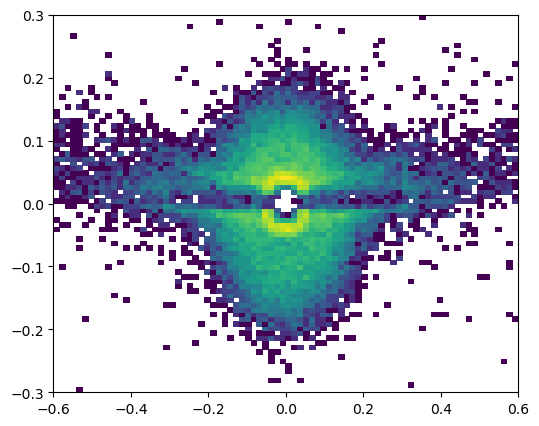

In [10]:
fig,ax2 = plt.subplots(figsize=(6,5), dpi=100)
_ = ax2.hist2d(FN_must.cluster_dphi, FN_must.cluster_deta,   
            bins=(80,80), range=((-0.6, 0.6),(-0.3, 0.3)), cmap="viridis", norm=colors.LogNorm())

## Check fraction of energy outside of supercluster

### Mustache

In [12]:
# False negative or lost energy
g_FN_must = FN_must[FN_must.is_seed==False].groupby("window_index", sort=False).agg(
    {"en_cluster": "sum", 
     "en_true":"first", 
     "en_seed": "first",
     "seed_eta": "first",
     "seed_phi": "first"})

g_FN_must["lost_fraction"] = g_FN_must["en_cluster"] / g_FN_must["en_true"]

# False positive or contamination
g_FP_must = FP_must[FP_must.is_seed==False].groupby("window_index", sort=False).agg(
    {"en_cluster": "sum", 
     "en_true":"first", 
     "en_seed": "first",
     "seed_eta": "first",
     "seed_phi": "first"})

g_FP_must["lost_fraction"] = g_FP_must["en_cluster"] / g_FP_must["en_true"]

#### DNN 

g_FN_dnn = data_in[(data_in.is_seed==False) & (data_in.y_shower < 0.88)].groupby("window_index", sort=False).agg(
    {"en_cluster": "sum", 
     "en_true":"first", 
     "en_seed": "first",
     "seed_eta": "first",
     "seed_phi": "first"})

g_FN_dnn["lost_fraction"] = g_FN_dnn["en_cluster"] / g_FN_dnn["en_true"]

g_FP_dnn = data_out[(data_out.is_seed==False) & (data_out.y_shower > 0.88)].groupby("window_index", sort=False).agg(
    {"en_cluster": "sum", 
     "en_true":"first", 
     "en_seed": "first",
     "seed_eta": "first",
     "seed_phi": "first"})

g_FP_dnn["lost_fraction"] = g_FP_dnn["en_cluster"] / g_FP_dnn["en_true"]

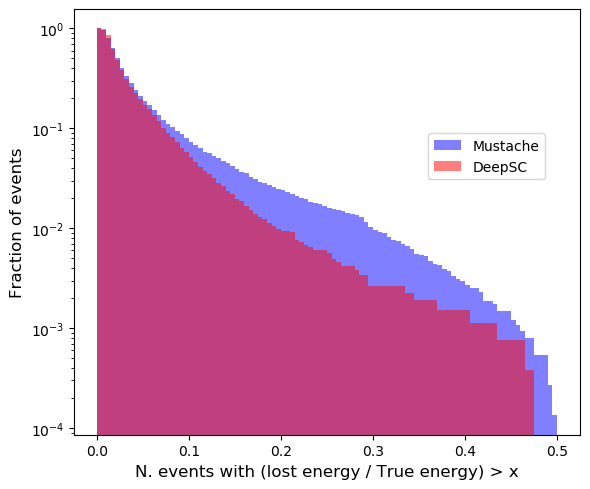

In [57]:
fig, ax1 = plt.subplots(figsize=(6,5), dpi=100)
ax1.hist(g_FN_must.lost_fraction, density=True, cumulative=-1, range=(0,0.5), bins=100, color="b", alpha=0.5, label="Mustache")
ax1.hist(g_FN_dnn.lost_fraction, density=True, cumulative=-1, range=(0,0.5), bins=100, color="r", alpha=0.5, label="DeepSC")
ax1.set_xlabel("Fraction of events with (lost energy / True energy) > x",fontsize=12)
ax1.set_ylabel("Fraction of events", fontsize=12)
ax1.set_yscale("log")
ax1.legend(loc=(0.7, 0.6))
fig.tight_layout()

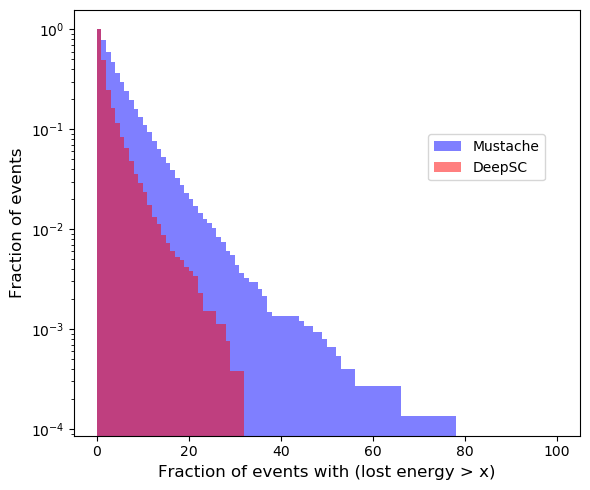

In [59]:
fig, ax1 = plt.subplots(figsize=(6,5), dpi=100)
ax1.hist(g_FN_must.en_cluster, density=True, cumulative=-1, range=(0,100), bins=100, color="b", alpha=0.5, label="Mustache")
ax1.hist(g_FN_dnn.en_cluster, density=True, cumulative=-1, range=(0,100), bins=100, color="r", alpha=0.5, label="DeepSC")
ax1.set_title("Fraction of events with (lost energy > x)",fontsize=18)
ax1.set_xlabel("Lost energy (GeV)")
ax1.set_ylabel("Fraction of events", fontsize=12)
ax1.set_yscale("log")
ax1.legend(loc=(0.7, 0.6))
fig.tight_layout()

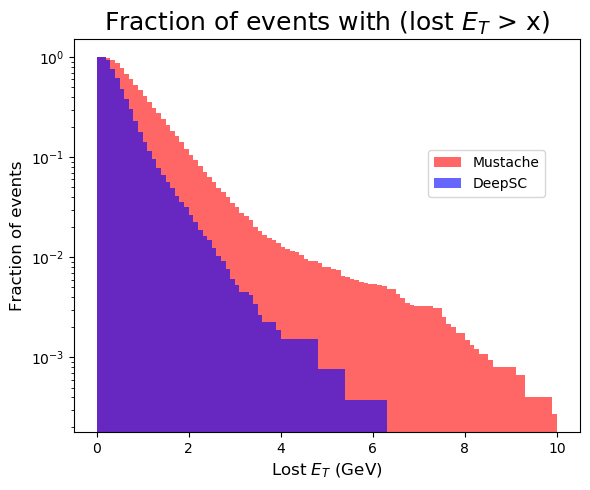

In [69]:
fig, ax1 = plt.subplots(figsize=(6,5), dpi=100)
ax1.hist(g_FN_must.en_cluster / np.cosh(g_FN_must.seed_eta), density=True, cumulative=-1, range=(0,10), bins=100, color="r", alpha=0.6, label="Mustache")
ax1.hist(g_FN_dnn.en_cluster / np.cosh(g_FN_dnn.seed_eta), density=True, cumulative=-1, range=(0,10), bins=100, color="b", alpha=0.6, label="DeepSC")
ax1.set_title("Fraction of events with (lost $E_T$ > x)",fontsize=18)
ax1.set_xlabel("Lost $E_T$ (GeV)", fontsize=12)
ax1.set_ylabel("Fraction of events", fontsize=12)
ax1.set_yscale("log")
ax1.legend(loc=(0.7, 0.6))
fig.tight_layout()

In [ ]:
fig, ax1 = plt.subplots(figsize=(6,5), dpi=100)
ax1.hist(g_FN_must.en_cluster / np.cosh(g_FN_must.seed_eta), density=True, cumulative=-1, range=(0,10), bins=100, color="b", alpha=0.5, label="Mustache")
ax1.hist(g_FN_dnn.en_cluster / np.cosh(g_FN_dnn.seed_eta), density=True, cumulative=-1, range=(0,10), bins=100, color="r", alpha=0.5, label="DeepSC")
ax1.set_xlabel("Fraction of events with (lost $E_T$ > x)",fontsize=12)
ax1.set_ylabel("Fraction of events", fontsize=12)
ax1.set_yscale("log")
ax1.legend(loc=(0.7, 0.6))
fig.tight_layout()

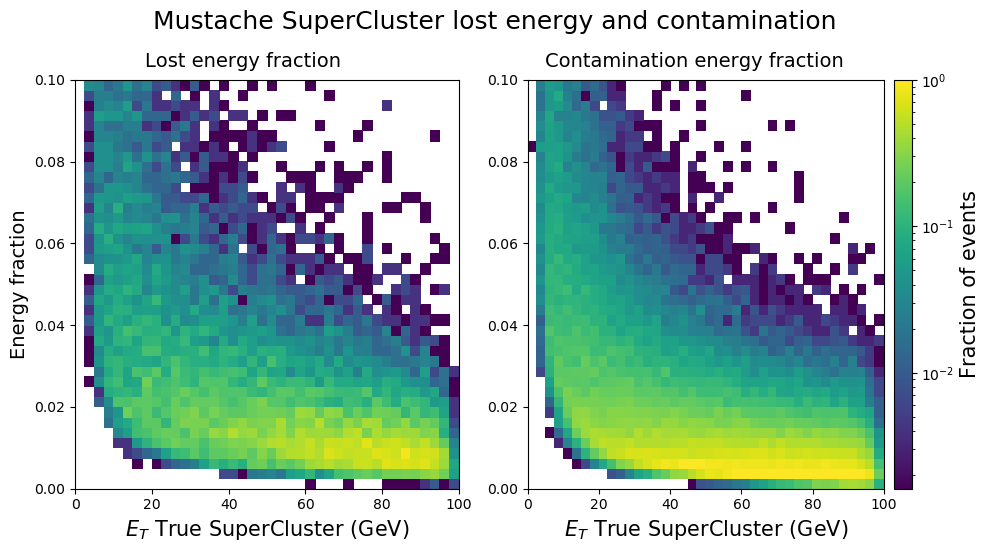

In [29]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10,5), dpi=100)

h1_, *_, h1 = ax1.hist2d(g_FN_must.en_true / np.cosh(g_FN_must.seed_eta),g_FN_must.lost_fraction,  range=((0,100),(0,0.1)),  
                             bins=(40,40), norm=colors.LogNorm(), density=True, vmax=1)
ax1.set_ylabel("Energy fraction", fontsize=14)
ax1.set_xlabel("$E_T$ True SuperCluster (GeV)", fontsize=15)

h2_, *_, h2 = ax2.hist2d(g_FP_must.en_true / np.cosh(g_FP_must.seed_eta), g_FP_must.lost_fraction, range=((0,100),(0,0.1)), 
                         bins=(40,40), norm=colors.LogNorm(), density=True,  vmax=1)
#ax2.set_ylabel("Contamination energy fraction",fontsize=14)
ax2.set_xlabel("$E_T$ True SuperCluster (GeV)",fontsize=15)


divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)
cb = fig.colorbar(h2, cax=cax2 )
cb.set_label("Fraction of events", fontsize=15)

fig.text(0.5, 1.07, "Mustache SuperCluster lost energy and contamination", ha="center", va="center", fontsize=18)
fig.text(0.15, 0.98, "Lost energy fraction", fontsize=14 )
fig.text(0.55, 0.98, "Contamination energy fraction", fontsize=14 )

#plt.subplots_adjust(wspace = -.015, hspace=0.25)

fig.tight_layout()

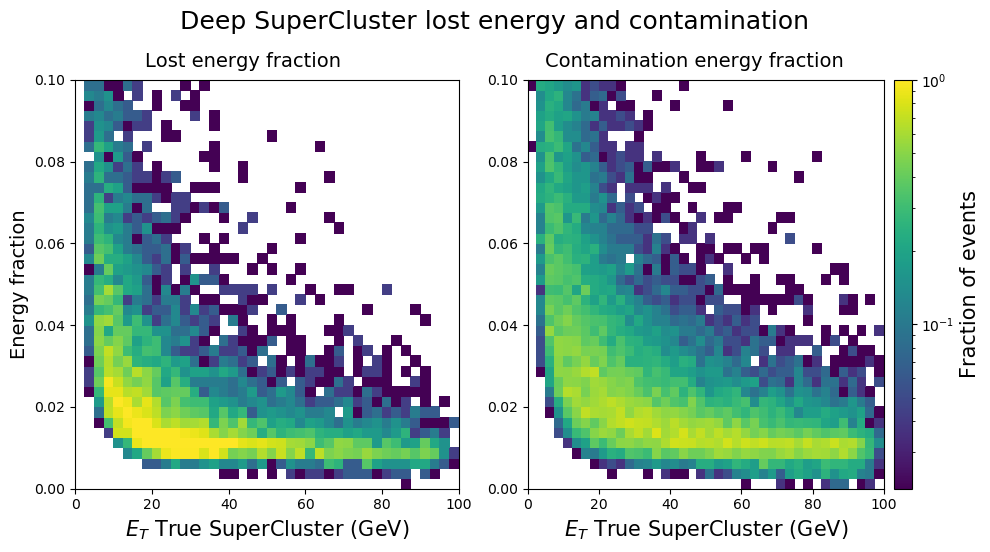

In [32]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10,5), dpi=100)


h1_, *_, h1 = ax1.hist2d(g_FN_dnn.en_true / np.cosh(g_FN_dnn.seed_eta), g_FN_dnn.lost_fraction, range=((0,100),(0,0.1)),  
                             density=True, bins=(40,40), norm=colors.LogNorm(), vmax=1)
ax1.set_ylabel("Energy fraction", fontsize=14)
ax1.set_xlabel("$E_T$ True SuperCluster (GeV)", fontsize=15)


h2_, *_, h2 = ax2.hist2d( g_FP_dnn.en_true / np.cosh(g_FP_dnn.seed_eta), g_FP_dnn.lost_fraction, range=((0,100),(0,0.1)),  
                         density = True, bins=(40,40), norm=colors.LogNorm(), vmax=1)
#ax2.set_ylabel("Contamination energy fraction",fontsize=14)
ax2.set_xlabel("$E_T$ True SuperCluster (GeV)",fontsize=15)

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)
cb = fig.colorbar(h1, cax=cax2 )
cb.set_label("Fraction of events", fontsize=15)

fig.text(0.5, 1.07, "Deep SuperCluster lost energy and contamination", ha="center", va="center", fontsize=18)
fig.text(0.15, 0.98, "Lost energy fraction", fontsize=14 )
fig.text(0.55, 0.98, "Contamination energy fraction", fontsize=14 )

fig.tight_layout()